# Assembly name prediction

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from tqdm import tqdm
from collections import Counter
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from numpy.linalg import norm
from transformers import BertTokenizer, TFBertModel, TFAutoModel
from keras import layers


import tensorflow_addons as tfa

## Simple baseline with BERT and cosine similarity

### Pre-process data for task

In [2]:
data_path = "../data/data_02.feather"
data = pd.read_feather(data_path)

In [3]:
data = data.dropna(subset=["assembly_name", "part_names"])
data = data.drop(columns=["assembly_id", 'assembly_description'])
data.head()

assembly_name                                         part_names
0          Lava Lamp 2                  [Blob3, Blob2, Blob1, Glass, Cap]
1  Sample - Headphones  [Pivot hinge, Headphone hinge, Telescope hinge...
4           Coffee Mug                                         [Mug, Lid]
5  Dave's Handsome Mug                                [Lid, Seal, Vessel]
9    Mechanical Pencil  [Eraser, Pencil Lead, Rubber Grip, Gripper Rod...

In [4]:
# Deduplicate
print(f"Tot: {len(data)}")
print(f"Unique: {len(data['assembly_name'].unique())}")
data = data[~data['part_names'].apply(tuple).duplicated()]
print(f"\nAfter dedup: {len(data)}")
print(f"Unique: {len(data['assembly_name'].unique())}")

Tot: 88886
Unique: 67834

After dedup: 61725
Unique: 54034


### Clean assembly names

In [5]:
def process_assembly_names(string):
    string = string.replace('.x_t', '')
    string = string.replace('.stp', '')
    string = string.replace('.step', '')
    string = string.replace('.zip', '')
    string = ' '.join(re.findall('.+?(?:(?<=[a-z])(?=[A-Z])|(?<=[A-Z])(?=[A-Z][a-z])|$)', string))  # splits camelCase into camel case
    string = ' '.join(re.split('(\s+|^)([A-Za-z]+)\d+(\s+|$)', string))  # removes number at the end
    string = string.lower()
    string = string.replace('_', ' ')
    string = string.replace('-', ' ')
    string = string.replace('[', ' ')
    string = string.replace(']', ' ')
    string = string.replace('(', ' ')
    string = string.replace(')', ' ')
    string = string.replace('?', ' ')
    string = string.replace('*', ' ')
    string = string.replace('copy of', ' ')
    string = string.replace('copy', ' ')
    string = " ".join(string.split())

    return string


data['assembly_name_clean'] = data.apply(lambda row: process_assembly_names(row.assembly_name), axis=1)

In [6]:
print(f"After dedup: {len(data)}")
print(f"Unique: {len(data['assembly_name_clean'].unique())}")

After dedup: 61725
Unique: 49601


### Clean part names

In [7]:
def process_part_names(list):
    part_names = []
    for string in list:
        if "MANIFOLD_SOLID_BREP" in string:
            return np.nan
        string = string.replace('.x_t', '')
        string = string.replace('.stp', '')
        string = string.replace('.step', '')
        string = string.replace('.dwg', '')
        string = string.replace('.zip', '')
        string = ' '.join(re.findall('.+?(?:(?<=[a-z])(?=[A-Z])|(?<=[A-Z])(?=[A-Z][a-z])|$)', string))  # splits camelCase into camel case
        string = ' '.join(re.split('(\s+|^)([A-Za-z]+)\d+(\s+|$)', string))  # removes number at the end
        string = string.lower()
        string = string.replace('_', ' ')
        string = string.replace('-', ' ')
        string = string.replace('[', ' ')
        string = string.replace(']', ' ')
        string = string.replace('(', ' ')
        string = string.replace(')', ' ')
        string = string.replace('?', ' ')
        string = string.replace('*', ' ')
        string = string.replace('copy of', ' ')
        string = string.replace('copy', ' ')
        string = " ".join(string.split())

        part_names.append(string)

    return part_names


data['part_names_clean'] = data.apply(lambda row: process_part_names(row.part_names), axis=1)
data.dropna(subset=['part_names_clean'], inplace=True)


In [8]:
data.head()

assembly_name                                         part_names  \
0          Lava Lamp 2                  [Blob3, Blob2, Blob1, Glass, Cap]   
1  Sample - Headphones  [Pivot hinge, Headphone hinge, Telescope hinge...   
4           Coffee Mug                                         [Mug, Lid]   
5  Dave's Handsome Mug                                [Lid, Seal, Vessel]   
9    Mechanical Pencil  [Eraser, Pencil Lead, Rubber Grip, Gripper Rod...   

   assembly_name_clean                                   part_names_clean  
0          lava lamp 2                     [blob, blob, blob, glass, cap]  
1    sample headphones  [pivot hinge, headphone hinge, telescope hinge...  
4           coffee mug                                         [mug, lid]  
5  dave's handsome mug                                [lid, seal, vessel]  
9    mechanical pencil  [eraser, pencil lead, rubber grip, gripper rod...

### Create sentences for BERT

In [9]:
def create_sentences(data_df, deduplicate_part_names=True):
    part_name_sentences = []
    assembly_name_sentences = []

    for index, row in data_df.iterrows():
        # if len(row['part_names_clean']) > 1:
        # build single part name sentence
        part_name_sentence = "An assembly containing the following parts: "
        if deduplicate_part_names:
            part_names = set(row['part_names_clean'])
        else:
            part_names = row['part_names_clean']
        for part_name in part_names:
            part_name_sentence +=  f"{part_name}, "
        part_name_sentence = part_name_sentence[:-2] + "."
        part_name_sentences.append(part_name_sentence)

        # build single assembly name sentence
        assembly_name_sentence = f"An assembly with the name '{row['assembly_name_clean']}'"
        assembly_name_sentences.append(assembly_name_sentence)
    return part_name_sentences, assembly_name_sentences

In [10]:
part_name_sentences, assembly_name_sentences = create_sentences(data)

In [11]:
print(len(part_name_sentences))
part_name_sentences[:10]

61601


['An assembly containing the following parts: cap, blob, glass.',
 'An assembly containing the following parts: headphone speaker, headphone hinge, upper band, telescope hinge, pivot hinge.',
 'An assembly containing the following parts: mug, lid.',
 'An assembly containing the following parts: seal, lid, vessel.',
 'An assembly containing the following parts: eraser, pencil lead, gripper rod, button release, rubber grip, lead gripper.',
 'An assembly containing the following parts: peg, link, plate, wheel, block.',
 'An assembly containing the following parts: head, default, b18.3.5m 4 x 0.7 x 10 socket fchs 10s, torch holder.',
 'An assembly containing the following parts: cap, bottle base.',
 'An assembly containing the following parts: symmetry of btr m axe corps levier, seat, btr m axe corps levier, arm, main, x2 00e9 x0 crou colonne, symmetry of ecrou btr m axe levier, rondelle, goupille axe levier, axe amorto rotatif, arm, pivot, bras de levier, nose, bouton r x2 00e9 x0 glage g

In [12]:
print(len(assembly_name_sentences))
assembly_name_sentences[:10]

61601


["An assembly with the name 'lava lamp 2'",
 "An assembly with the name 'sample headphones'",
 "An assembly with the name 'coffee mug'",
 "An assembly with the name 'dave's handsome mug'",
 "An assembly with the name 'mechanical pencil'",
 "An assembly with the name 'os kinematics'",
 "An assembly with the name 'torch light for bike'",
 "An assembly with the name 'bottle'",
 "An assembly with the name 'concept vehicle'",
 "An assembly with the name 'mounting arm'"]

### Train test split

In [13]:
test_data = pd.read_csv('../data/test.csv')

In [14]:
test_strings, test_labels = create_sentences(data.loc[test_data['Unnamed: 0'].tolist()])

In [15]:
test_strings[:5]

['An assembly containing the following parts: end 1, side 1, side 2, short divider, end 2, long divider.',
 'An assembly containing the following parts: 20mm stack.',
 'An assembly containing the following parts: internalcomb, basebottomkeyhalf, basebottomkeyotherhalf, boxlid, windholder, mainbox, barform, basetopkey.',
 'An assembly containing the following parts: nozzle, v slot 20x60x500 linear rail, fake support, 184, l 2112kk cage, carrage mount prt8, vt1m3x30, heater block^e3d nozzle v, 167, 145, turbine, 181, motor shaft, frame b3, boden lever arm, heater, component, 160, 182, timming pulley 16t g2, bed center, 175, fitting, 174, 149, bl touch, 183, 144, 159, arm, l 2112kk ir, frame b2, 151, vt3m4x12, steel tube, 142, l 2112kk ball, extruder bridge aluminium, 162, 178, boden frame, rail cross part, pivot shaft, 177, carrage prt6, 157, extruder grove wheel\\x2\\00d8\\x0\\13, m3cerated nut, pin\\x2\\00d8\\x0\\5, bed rotor mount, lead screw prt2, 169, wheel a1, shaft top prt4, 146, 

In [16]:
test_labels[:5]

["An assembly with the name 'box shell version'",
 "An assembly with the name '20mm stack'",
 "An assembly with the name 'ww sport base bar box'",
 "An assembly with the name 'circle builder'",
 "An assembly with the name '2238 375.step'"]

In [17]:
train_data = pd.read_csv('../data/train.csv')

In [18]:
train_strings, train_labels = create_sentences(data.loc[train_data['Unnamed: 0'].tolist()])

In [19]:
train_strings[:5]

['An assembly containing the following parts: 27135t32.',
 'An assembly containing the following parts: lpg, atteinte poignee, cercle manoeuvre, porte entr\\x2\\00e9\\x0\\e, \\x2\\00e9\\x0\\tag\\x2\\00e8\\x0\\re, paroie cab 1, tapis kettler track 9, pot 1, pot 2, baignoire, ouverture porte lpg, ergometer x, faut sal att, cheminement, paroie cab 2, multi fitness center, armoire lpg, chair, porte toi 1, engin reeduc, batiment 210616, lavabo, sortie sec, ouverture porte toi 1, machine laver, ouverture porte chaud, elec coffret, pot 4, porte chaudiere, table mass fixe, ouverture porte 2, paroie bureau toilettes, chaise bureau, cabine salle attent, porte bain, chaudiere, porte lpg, plat pow, toilettes, satura eext, table mass regl, meuble rang bureau, batiment, porte toilettes, toilette.',
 'An assembly containing the following parts: runlarger small insert.',
 'An assembly containing the following parts: entaniya fisheye.',
 'An assembly containing the following parts: res 0805, 104031 081

In [20]:
train_labels[:5]

["An assembly with the name 'mh 50 assembly'",
 "An assembly with the name '20160612 local complet'",
 "An assembly with the name 'runlarger small insert'",
 "An assembly with the name 'overview one mark v'",
 "An assembly with the name 'battery case'"]

In [21]:
print(f"Length of train strings: {len(train_strings)}")
print(f"Length of train labels: {len(train_labels)}")
print(f"Length of test strings: {len(test_strings)}")
print(f"Length of test labels: {len(test_labels)}")

Length of train strings: 49280
Length of train labels: 49280
Length of test strings: 12321
Length of test labels: 12321


### Tokenize and create embeddings

In [22]:
model_checkpoint = 'bert-base-uncased'
bert_tokenizer = BertTokenizer.from_pretrained(model_checkpoint)
bert_model = TFBertModel.from_pretrained(model_checkpoint)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [23]:
def create_embeddings(strings, labels, tokenizer, model, max_length=128, batch_size=100, pooling='cls'):

    test_strings_embeddings_batched, test_labels_embeddings_batched = [], []
    num_batches = len(strings)//batch_size
    for batch in tqdm(range(num_batches), total=num_batches):
        test_strings_token = tokenizer(strings[batch*batch_size:(batch+1)*batch_size],
                      max_length=max_length,
                      truncation=True,
                      padding=True, # TODO: check the dimensions and whether it needs to be 'max_length'
                      return_tensors='tf')

        test_labels_tokens = tokenizer(labels[batch*batch_size:(batch+1)*batch_size],
                      max_length=max_length,
                      truncation=True,
                      padding=True, # TODO: check the dimensions and whether it needs to be 'max_length'
                      return_tensors='tf')

        test_strings_embeddings = model(test_strings_token)
        test_labels_embeddings = model(test_labels_tokens)

        if pooling == 'cls':
            test_strings_embeddings = test_strings_embeddings[0][:, 0, :]
            test_labels_embeddings = test_labels_embeddings[0][:, 0, :]
        else:
            test_strings_embeddings = test_strings_embeddings[1]
            test_labels_embeddings = test_labels_embeddings[1]
        test_strings_embeddings_batched.append(test_strings_embeddings)
        test_labels_embeddings_batched.append(test_labels_embeddings)

    return test_strings_embeddings_batched, test_labels_embeddings_batched

In [24]:
test_strings_embeddings, test_labels_embeddings = create_embeddings(test_strings, test_labels, bert_tokenizer, bert_model)

100%|██████████| 123/123 [01:27<00:00,  1.40it/s]


### Evaluate with cosine similarity and argmax

In [25]:
def evaluate_similarity(test_strings_embeddings_batches, test_labels_embeddings_batches, axis=0):
    similarity_batches = []
    for batch_id in range(len(test_strings_embeddings_batches)):
        test_strings_embeddings = tf.nn.l2_normalize(test_strings_embeddings_batches[batch_id], axis)
        test_labels_embeddings = tf.nn.l2_normalize(test_labels_embeddings_batches[batch_id], axis)

        similarity = test_strings_embeddings @ tf.transpose(test_labels_embeddings)
        similarity_batches.append(similarity)

    return similarity_batches

In [26]:
similarity_batches = evaluate_similarity(test_strings_embeddings, test_labels_embeddings)

[Text(0.5, 47.24444444444444, 'Part Names'),
 Text(74.44444444444444, 0.5, 'Assembly Names'),
 Text(0.5, 1.0, 'Cosine Similarity Between Assembly Names and Part Names')]

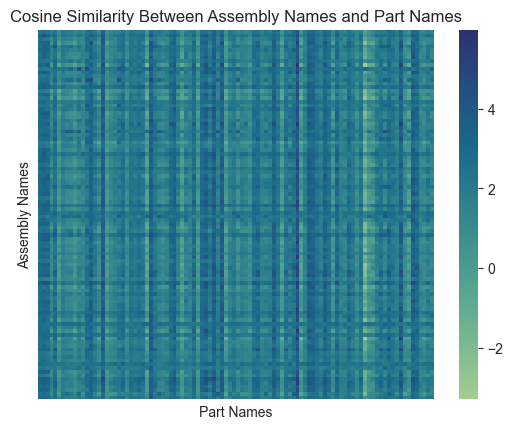

In [27]:
ax = sns.heatmap(similarity_batches[0], cmap="crest", xticklabels=False, yticklabels=False) #, annot=True)
ax.set(xlabel="Part Names", ylabel="Assembly Names", title="Cosine Similarity Between Assembly Names and Part Names")

In [28]:
pred = []
true = []
for index, value in enumerate(similarity_batches[0][:10]):
    predicted = np.argmax(value)
    actual = index
    pred.append(predicted)
    true.append(actual)
    print(f"Predicted: {predicted} | Actual: {index}")

Predicted: 65 | Actual: 0
Predicted: 65 | Actual: 1
Predicted: 65 | Actual: 2
Predicted: 65 | Actual: 3
Predicted: 91 | Actual: 4
Predicted: 28 | Actual: 5
Predicted: 94 | Actual: 6
Predicted: 65 | Actual: 7
Predicted: 65 | Actual: 8
Predicted: 65 | Actual: 9


In [26]:
def evaluate_accuracy(similarity_batches):
    top_ks = [1,5,10]
    for k in top_ks:
        tot_accuracy = []
        for batch in similarity_batches:
            top_k_values = np.argsort(-batch, axis=1)[:,:k]
            correct = 0
            for index, row in enumerate(top_k_values):
                if index in row:
                    correct += 1
            accuracy = correct / len(batch)
            tot_accuracy.append(accuracy)


        print(f"Top-{k} accuracy: {np.mean(tot_accuracy)}")

In [30]:
evaluate_accuracy(similarity_batches)

Top-1 accuracy: 0.05788617886178862
Top-5 accuracy: 0.15813008130081302
Top-10 accuracy: 0.23983739837398377


## Fine-tuned BERT

### Load fine-tuned model from checkpoint and get embeddings

In [34]:
checkpoint_dir = '../MLM/fine_tuning/bert_fine_tuned_2'
bert_tokenizer_2 = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model_2 = TFBertModel.from_pretrained(checkpoint_dir)

Some layers from the model checkpoint at ../MLM/fine_tuning/bert_fine_tuned_2 were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at ../MLM/fine_tuning/bert_fine_tuned_2 and are newly initialized: ['bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [35]:
test_strings_embeddings, test_labels_embeddings = create_embeddings(test_strings, test_labels, bert_tokenizer_2, bert_model_2)

100%|██████████| 123/123 [01:30<00:00,  1.36it/s]


### Evaluate

In [36]:
similarity_batches = evaluate_similarity(test_strings_embeddings, test_labels_embeddings)

[Text(0.5, 47.24444444444444, 'Part Names'),
 Text(74.44444444444444, 0.5, 'Assembly Names'),
 Text(0.5, 1.0, 'Cosine Similarity Between Assembly Names and Part Names')]

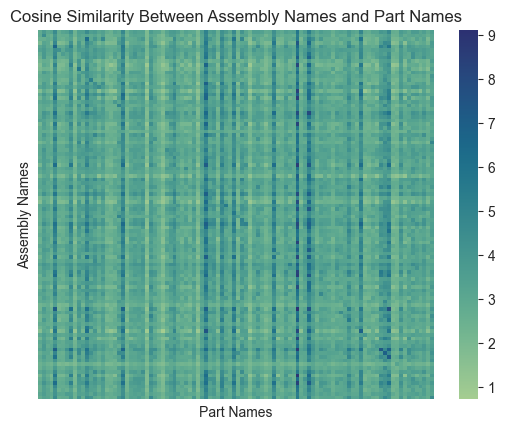

In [37]:
ax = sns.heatmap(similarity_batches[0], cmap="crest", xticklabels=False, yticklabels=False) #, annot=True)
ax.set(xlabel="Part Names", ylabel="Assembly Names", title="Cosine Similarity Between Assembly Names and Part Names")

In [38]:
for index, value in enumerate(similarity_batches[0][:10]):
    predicted = np.argmax(value)
    actual = index
    print(f"Predicted: {predicted} | Actual: {index}")

Predicted: 65 | Actual: 0
Predicted: 65 | Actual: 1
Predicted: 12 | Actual: 2
Predicted: 65 | Actual: 3
Predicted: 4 | Actual: 4
Predicted: 65 | Actual: 5
Predicted: 65 | Actual: 6
Predicted: 65 | Actual: 7
Predicted: 65 | Actual: 8
Predicted: 65 | Actual: 9


In [39]:
evaluate_accuracy(similarity_batches)

Top-1 accuracy: 0.09447154471544716
Top-5 accuracy: 0.2099186991869919
Top-10 accuracy: 0.30349593495934957


## CLIP-like Contrastive Pre-training
The code for the dual encoder model was adapted from [this example](https://keras.io/examples/nlp/nl_image_search/).

### Pre-process test data and create data loader for training data
We are implementing the batched data-loader as described in [the notebook provided](https://github.com/datasci-w266/2022-fall-main/blob/master/materials/walkthrough_notebooks/keras_with_limited_ram/keras_training_with_limited_ram.ipynb).

In [27]:
train_data_path = '../data/train.csv'

In [22]:
model_checkpoint = 'bert-base-uncased'
bert_tokenizer = BertTokenizer.from_pretrained(model_checkpoint)

In [28]:
def preprocess_data(raw_data, wanted_data, tokenizer, max_length=128):
    part_name_sentences, assembly_name_sentences = create_sentences(raw_data.loc[wanted_data['Unnamed: 0'].tolist()])

    parts_tokens = tokenizer(part_name_sentences,
                  max_length=max_length,
                  truncation=True,
                  padding='max_length',
                  return_tensors='tf')

    # Extract encoded features and labels, add to corresponding lists
    part_input_ids = np.array(parts_tokens["input_ids"], dtype="int32")
    part_attention_masks = np.array(parts_tokens["attention_mask"], dtype="int32")
    part_token_type_ids = np.array(parts_tokens["token_type_ids"], dtype="int32")

    assemblies_tokens = tokenizer(assembly_name_sentences,
                  max_length=max_length,
                  truncation=True,
                  padding='max_length',
                  return_tensors='tf')

    # Extract encoded features and labels, add to corresponding lists
    assembly_input_ids = np.array(assemblies_tokens["input_ids"], dtype="int32")
    assembly_attention_masks = np.array(assemblies_tokens["attention_mask"], dtype="int32")
    assembly_token_type_ids = np.array(assemblies_tokens["token_type_ids"], dtype="int32")

    features = {
        'assembly_inputs': [part_input_ids, part_attention_masks, part_token_type_ids],
        'part_inputs': [assembly_input_ids, assembly_attention_masks, assembly_token_type_ids]
    }

    return features

In [29]:
class DataGeneratorFromFile(tf.keras.utils.Sequence):
    def __init__(self,
                 tokenizer,
                 n_examples,
                 data_filename,
                 max_length=128,
                 batch_size=100,
                 shuffle=True):

        self.tokenizer = tokenizer
        self.n_examples = n_examples
        self.data_filename = data_filename
        self.max_length = max_length
        self.batch_size = batch_size
        self.shuffle = shuffle

        # Initialize row order, call on_epoch_end to shuffle row indices
        self.row_order = np.arange(1, self.n_examples+1)
        self.on_epoch_end()

    def __len__(self):
        return self.n_examples // self.batch_size

    def __getitem__(self, idx):
        batch_start = idx * self.batch_size
        batch_end = (idx + 1) * self.batch_size

        # Indices to skip are the ones in the shuffled row_order before and
        # after the chunk we'll use for this batch
        batch_idx_skip = self.row_order[:batch_start] + self.row_order[batch_end:]
        train_data_df = pd.read_csv(self.data_filename, skiprows=batch_idx_skip)

        batch_data = preprocess_data(
            data,
            train_data_df,
            self.tokenizer,
            self.max_length
        )

        return batch_data

    def on_epoch_end(self):
        if self.shuffle:
            self.row_order = list(np.random.permutation(self.row_order))

In [30]:
test_data_preprocessed = preprocess_data(data, test_data, tokenizer=bert_tokenizer, max_length=128)

## Build Model

In [61]:
# Implement the text encoder
def create_text_encoder(train_layers=5, bert_model_name='bert-base-uncased', max_length=128, pool_token='cls', attention=False, fully_connected_layers=None):
    bert_model = TFAutoModel.from_pretrained(bert_model_name)

    if train_layers == -1:
        # Freeze all layers of pre-trained BERT model
        bert_model.trainable = False
    else:
        bert_model.trainable = True
        # Restrict training to the train_layers outer transformer layers
        retrain_layers = []
        for retrain_layer_number in range(train_layers):
            layer_code = '_' + str(11 - retrain_layer_number)
            retrain_layers.append(layer_code)
        print('retrain layers: ', retrain_layers)
        for w in bert_model.weights:
            if not any([x in w.name for x in retrain_layers]):
                # print('freezing: ', w.name)
                w._trainable = False

    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}

    bert_out = bert_model(bert_inputs)

    if attention:
        print("using attention layer")
        output = bert_out.last_hidden_state
        attn_output = layers.MultiHeadAttention(num_heads=8, key_dim=100)(output, output)
        max_pool = layers.GlobalMaxPooling1D()(attn_output)
        dropout_output = layers.Dropout(0.3)(max_pool)
        output = layers.Dense(512, activation="relu")(dropout_output)
    else:
        if pool_token == 'pool':
            print("Using pool")
            output = bert_out[1]
        elif pool_token == 'cls':
            print("Using cls")
            output = bert_out[0][:, 0, :]
        else:
            raise Exception(f"Output not supported: {pool_token}")

    if fully_connected_layers is not None:
        print("Adding fully connected layers")
        for i in range(fully_connected_layers - 1):
            output = tf.keras.layers.Dense(768, activation='tanh', name=f'hidden_layer_{i}')(output)
            output = tf.keras.layers.Dropout(0.2)(output)

        output = tf.keras.layers.Dense(768, activation='tanh', name=f'hidden_layer_last')(output)   # TODO: try activation=None, 768 dimensions
        # output = tf.keras.layers.Dropout(0.3)(output)

    model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[output], name='text_encoder')
    return model

In [32]:
# Implement the dual encoder
class DualEncoder(keras.Model):
    def __init__(self, text_encoder, temperature=1.0, **kwargs):
        super(DualEncoder, self).__init__(**kwargs)
        self.text_encoder = text_encoder
        self.temperature = temperature
        self.loss_tracker = keras.metrics.Mean(name="loss")

    @property
    def metrics(self):
        return [self.loss_tracker]

    def call(self, inputs, training=False):
        assembly_inputs, part_inputs = inputs['assembly_inputs'], inputs['part_inputs']
        assembly_embeddings = self.text_encoder(assembly_inputs, training=training)
        parts_embeddings = self.text_encoder(part_inputs, training=training)

        return assembly_embeddings, parts_embeddings

    def compute_loss(self, assembly_embeddings, parts_embeddings):
        # logits[i][j] is the dot_similarity(caption_i, image_j).
        logits = (
            tf.matmul(assembly_embeddings, parts_embeddings, transpose_b=True)
            / self.temperature
        )
        # images_similarity[i][j] is the dot_similarity(image_i, image_j).
        parts_similarity = tf.matmul(
            parts_embeddings, parts_embeddings, transpose_b=True
        )
        # captions_similarity[i][j] is the dot_similarity(caption_i, caption_j).
        assembly_similarity = tf.matmul(
            assembly_embeddings, assembly_embeddings, transpose_b=True
        )
        # targets[i][j] = avarage dot_similarity(caption_i, caption_j) and dot_similarity(image_i, image_j).
        targets = keras.activations.softmax(
            (parts_similarity + assembly_similarity) / (2 * self.temperature)
        )
        # Compute the loss for the captions using crossentropy
        assembly_loss = keras.losses.categorical_crossentropy(
            y_true=targets, y_pred=logits, from_logits=True
        )
        # Compute the loss for the images using crossentropy
        parts_loss = keras.losses.categorical_crossentropy(
            y_true=tf.transpose(targets), y_pred=tf.transpose(logits), from_logits=True
        )
        # Return the mean of the loss over the batch.
        return (assembly_loss + parts_loss) / 2

    def train_step(self, inputs):
        if isinstance(inputs, tuple):
            inputs = inputs[0]
        with tf.GradientTape() as tape:
            # Forward pass
            assembly_embeddings, parts_embeddings = self(inputs, training=True)
            loss = self.compute_loss(assembly_embeddings, parts_embeddings)
        # Backward pass
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        # Monitor loss
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, inputs):
        if isinstance(inputs, tuple):
            inputs = inputs[0]
        assembly_embeddings, parts_embeddings = self(inputs, training=False)
        loss = self.compute_loss(assembly_embeddings, parts_embeddings)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

In [56]:
# Train the dual encoder model
num_epochs = 5  # In practice, train for at least 30 epochs
train_layers = 1
temperature = 0.05
pool_out = 'cls'

text_encoder = create_text_encoder(train_layers=train_layers, max_length=128)
dual_encoder = DualEncoder(text_encoder, temperature=temperature)
dual_encoder.compile(optimizer=tfa.optimizers.AdamW(learning_rate=0.001, weight_decay=0.001))

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


retrain layers:  ['_11']
freezing:  <tf.Variable 'tf_bert_model_2/bert/embeddings/word_embeddings/weight:0' shape=(30522, 768) dtype=float32, numpy=
array([[-0.01018257, -0.06154883, -0.02649689, ..., -0.01985357,
        -0.03720997, -0.00975152],
       [-0.01170495, -0.06002603, -0.03233192, ..., -0.01681456,
        -0.04009988, -0.0106634 ],
       [-0.01975381, -0.06273633, -0.03262176, ..., -0.01650258,
        -0.04198876, -0.00323178],
       ...,
       [-0.02176224, -0.0556396 , -0.01346345, ..., -0.00432698,
        -0.0151355 , -0.02489496],
       [-0.04617237, -0.05647721, -0.00192082, ...,  0.01568751,
        -0.01387033, -0.00945213],
       [ 0.00145601, -0.08208051, -0.01597912, ..., -0.00811687,
        -0.04746607,  0.07527421]], dtype=float32)>
freezing:  <tf.Variable 'tf_bert_model_2/bert/embeddings/token_type_embeddings/embeddings:0' shape=(2, 768) dtype=float32, numpy=
array([[ 0.00043164,  0.01098826,  0.00370439, ..., -0.00661185,
        -0.00336983, -0.008

In [26]:
train_data_generator = DataGeneratorFromFile(
    tokenizer=bert_tokenizer,
    n_examples=len(pd.read_csv(train_data_path)),
    data_filename=train_data_path,
    batch_size=100
)

# Create a learning rate scheduler callback.
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3)
# Create an early stopping callback.
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

history = dual_encoder.fit(
    train_data_generator,
    epochs=num_epochs,
    validation_data=test_data_preprocessed,
    callbacks=[reduce_lr] # , early_stopping],
)
print("Training completed. Saving text encoder...")
text_encoder.save(f"text_encoder_{num_epochs}_{train_layers}_{pool_out}_{temperature}")
print("Models are saved.")

training: False
2
<class 'dict'>
{'assembly_inputs': (<tf.Tensor: shape=(100, 128), dtype=int32, numpy=
array([[ 101, 2019, 3320, ...,    0,    0,    0],
       [ 101, 2019, 3320, ...,    0,    0,    0],
       [ 101, 2019, 3320, ...,    0,    0,    0],
       ...,
       [ 101, 2019, 3320, ..., 8473, 1012,  102],
       [ 101, 2019, 3320, ...,    0,    0,    0],
       [ 101, 2019, 3320, ...,    0,    0,    0]])>, <tf.Tensor: shape=(100, 128), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])>, <tf.Tensor: shape=(100, 128), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])>), 'part_inputs': (<tf.Tensor: shape=(100, 128), dtype=int32, numpy=


INFO:tensorflow:Assets written to: text_encoder\assets


INFO:tensorflow:Assets written to: text_encoder\assets


Models are saved.


In [33]:
def visualize_history(history):
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title("model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "test"], loc="upper left")
    plt.show()

In [ ]:
visualize_history(history)

## Evaluate retrieval quality
To evaluate the dual encoder model, we use the captions as queries. We use the out-of-training-sample images and captions to evaluate the retrieval quality, using top k accuracy. A true prediction is counted if, for a given caption, its associated image is retrieved within the top k matches.

In [47]:
# Load text encoder
text_encoder = keras.models.load_model(f"text_encoder_{num_epochs}_{train_layers}_{pool_out}_{temperature}")

In [49]:
# Generate embeddings for the test data
test_part_embeddings = text_encoder.predict(test_data_preprocessed['part_inputs'])
test_assembly_embeddings = text_encoder.predict(test_data_preprocessed['assembly_inputs'])

386/386 [==============================] - 67s 175ms/step


In [50]:
# batch the embeddings into sets of 100
batch_size = 100
test_part_embeddings = np.array_split(test_part_embeddings, len(test_part_embeddings) / batch_size)
test_assembly_embeddings = np.array_split(test_assembly_embeddings, len(test_assembly_embeddings) / batch_size)

In [51]:
similarity_batches = evaluate_similarity(test_part_embeddings, test_assembly_embeddings)

[Text(0.5, 47.24444444444444, 'Part Names'),
 Text(74.44444444444444, 0.5, 'Assembly Names'),
 Text(0.5, 1.0, 'Cosine Similarity Between Assembly Names and Part Names')]

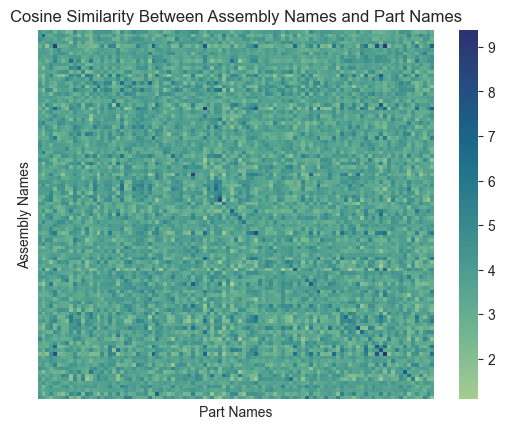

In [52]:
ax = sns.heatmap(similarity_batches[0], cmap="crest", xticklabels=False, yticklabels=False) #, annot=True)
ax.set(xlabel="Part Names", ylabel="Assembly Names", title="Cosine Similarity Between Assembly Names and Part Names")

In [53]:
for index, value in enumerate(similarity_batches[0][:10]):
    predicted = np.argmax(value)
    actual = index
    print(f"Predicted: {predicted} | Actual: {index}")

Predicted: 69 | Actual: 0
Predicted: 1 | Actual: 1
Predicted: 35 | Actual: 2
Predicted: 33 | Actual: 3
Predicted: 88 | Actual: 4
Predicted: 5 | Actual: 5
Predicted: 28 | Actual: 6
Predicted: 42 | Actual: 7
Predicted: 8 | Actual: 8
Predicted: 46 | Actual: 9


In [54]:
evaluate_accuracy(similarity_batches)

Top-1 accuracy: 0.2976293970860501
Top-5 accuracy: 0.48333574820896724
Top-10 accuracy: 0.5768220236657812


## Hyperparam search

[5, 1, 0.05, 'pool']


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/5
492/492 [==============================] - 578s 1s/step - loss: 36.1304 - val_loss: 2.9588 - lr: 0.0010
Epoch 2/5
492/492 [==============================] - 580s 1s/step - loss: 4.8255 - val_loss: 2.3367 - lr: 0.0010
Epoch 3/5
492/492 [==============================] - 579s 1s/step - loss: 3.7397 - val_loss: 2.3748 - lr: 0.0010
Epoch 4/5
492/492 [==============================] - 580s 1s/step - loss: 3.5857 - val_loss: 2.3472 - lr: 0.0010
Epoch 5/5
492/492 [==============================] - 579s 1s/step - loss: 3.4285 - val_loss: 2.2406 - lr: 0.0010
Training completed. Saving text encoder...


INFO:tensorflow:Assets written to: text_encoder_5_1_pool_0.05\assets


INFO:tensorflow:Assets written to: text_encoder_5_1_pool_0.05\assets


Model is saved: text_encoder_5_1_pool_0.05.


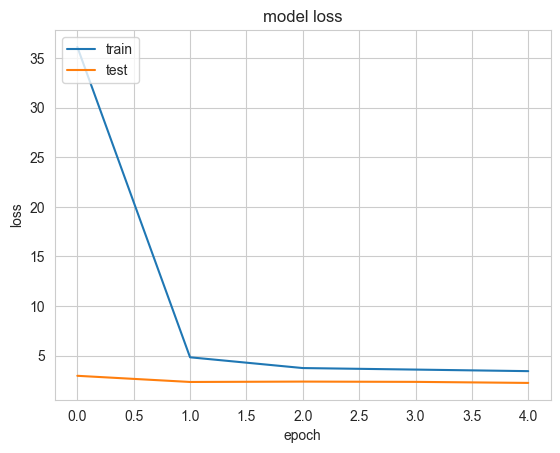

386/386 [==============================] - 71s 183ms/step
Top-1 accuracy: 0.32416968526120904
Top-5 accuracy: 0.5000587619737583
Top-10 accuracy: 0.5869749657892618
[5, 1, 0.03, 'cls']


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/5


492/492 [==============================] - 600s 1s/step - loss: 28.1055 - val_loss: 2.4964 - lr: 0.0010
Epoch 2/5
492/492 [==============================] - 585s 1s/step - loss: 4.5133 - val_loss: 2.9292 - lr: 0.0010
Epoch 3/5
492/492 [==============================] - 586s 1s/step - loss: 4.2489 - val_loss: 2.9502 - lr: 0.0010
Epoch 4/5
492/492 [==============================] - 587s 1s/step - loss: 4.0168 - val_loss: 2.8180 - lr: 0.0010
Epoch 5/5
492/492 [==============================] - 586s 1s/step - loss: 3.9730 - val_loss: 2.8672 - lr: 2.0000e-04
Training completed. Saving text encoder...


INFO:tensorflow:Assets written to: text_encoder_5_1_cls_0.03\assets


INFO:tensorflow:Assets written to: text_encoder_5_1_cls_0.03\assets


Model is saved: text_encoder_5_1_cls_0.03.


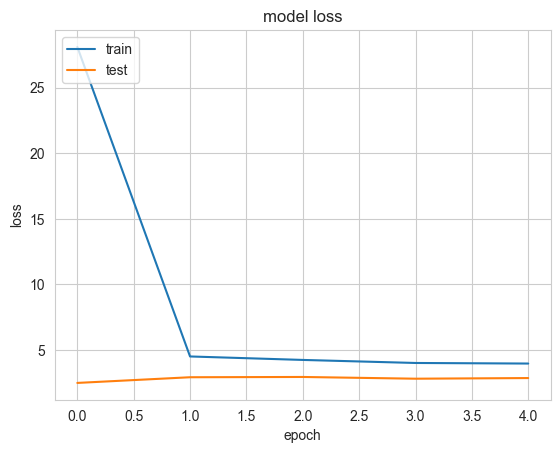

386/386 [==============================] - 73s 190ms/step
Top-1 accuracy: 0.18098687917572245
Top-5 accuracy: 0.3761225146904935
Top-10 accuracy: 0.4749054173710054
[5, 1, 0.07, 'cls']


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/5


492/492 [==============================] - 607s 1s/step - loss: 26.8458 - val_loss: 3.4986 - lr: 0.0010
Epoch 2/5
492/492 [==============================] - 586s 1s/step - loss: 5.6310 - val_loss: 3.3491 - lr: 0.0010
Epoch 3/5
492/492 [==============================] - 586s 1s/step - loss: 4.4120 - val_loss: 3.2121 - lr: 0.0010
Epoch 4/5
492/492 [==============================] - 580s 1s/step - loss: 4.1775 - val_loss: 3.0088 - lr: 0.0010
Epoch 5/5
492/492 [==============================] - 580s 1s/step - loss: 3.9611 - val_loss: 2.8138 - lr: 0.0010
Training completed. Saving text encoder...


INFO:tensorflow:Assets written to: text_encoder_5_1_cls_0.07\assets


INFO:tensorflow:Assets written to: text_encoder_5_1_cls_0.07\assets


Model is saved: text_encoder_5_1_cls_0.07.


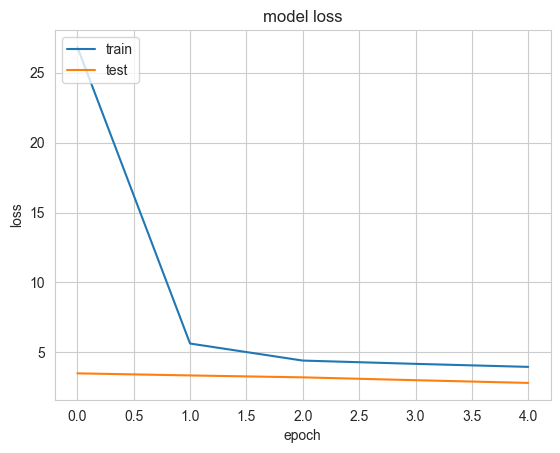

386/386 [==============================] - 72s 186ms/step
Top-1 accuracy: 0.23033405779602353
Top-5 accuracy: 0.4116405055139661
Top-10 accuracy: 0.5123770425823071
[5, 1, 0.1, 'cls']


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/5


492/492 [==============================] - 598s 1s/step - loss: 147.1465 - val_loss: 22.9641 - lr: 0.0010
Epoch 2/5
492/492 [==============================] - 579s 1s/step - loss: 138.0242 - val_loss: 3.4938 - lr: 0.0010
Epoch 3/5
492/492 [==============================] - 579s 1s/step - loss: 7.0703 - val_loss: 3.4691 - lr: 0.0010
Epoch 4/5
492/492 [==============================] - 578s 1s/step - loss: 4.8170 - val_loss: 3.4656 - lr: 0.0010
Epoch 5/5
492/492 [==============================] - 584s 1s/step - loss: 4.6240 - val_loss: 3.4658 - lr: 0.0010
Training completed. Saving text encoder...


INFO:tensorflow:Assets written to: text_encoder_5_1_cls_0.1\assets


INFO:tensorflow:Assets written to: text_encoder_5_1_cls_0.1\assets


Model is saved: text_encoder_5_1_cls_0.1.


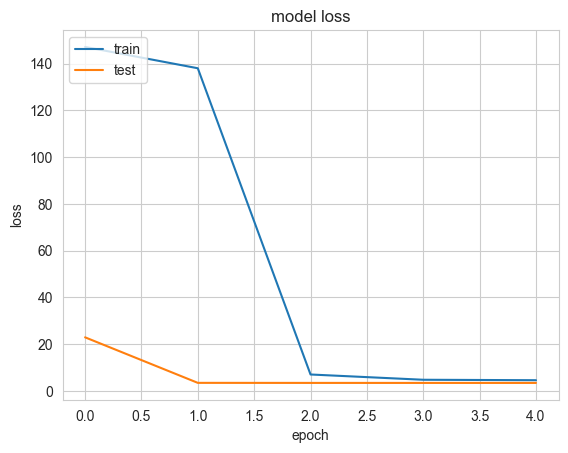

386/386 [==============================] - 73s 188ms/step
Top-1 accuracy: 0.010145697496578926
Top-5 accuracy: 0.0461788617886179
Top-10 accuracy: 0.0921162360138453
[5, 2, 0.05, 'cls']


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/5


492/492 [==============================] - 663s 1s/step - loss: 11.5513 - val_loss: 3.1835 - lr: 0.0010
Epoch 2/5
492/492 [==============================] - 642s 1s/step - loss: 4.6739 - val_loss: 2.7539 - lr: 0.0010
Epoch 3/5
492/492 [==============================] - 641s 1s/step - loss: 3.7916 - val_loss: 2.5667 - lr: 0.0010
Epoch 4/5
492/492 [==============================] - 641s 1s/step - loss: 3.5583 - val_loss: 2.4618 - lr: 0.0010
Epoch 5/5
492/492 [==============================] - 638s 1s/step - loss: 3.4608 - val_loss: 2.3722 - lr: 0.0010
Training completed. Saving text encoder...


INFO:tensorflow:Assets written to: text_encoder_5_2_cls_0.05\assets


INFO:tensorflow:Assets written to: text_encoder_5_2_cls_0.05\assets


Model is saved: text_encoder_5_2_cls_0.05.


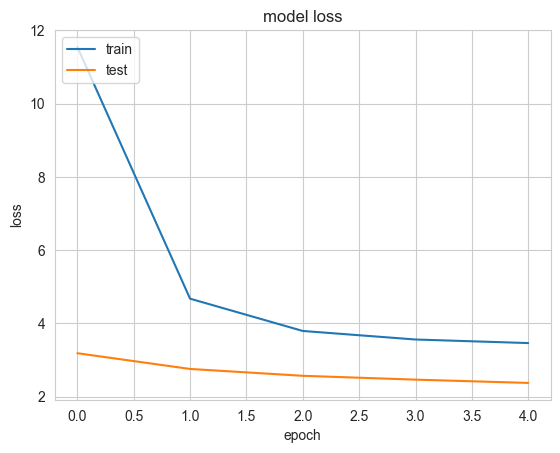

386/386 [==============================] - 70s 182ms/step
Top-1 accuracy: 0.3110086130564276
Top-5 accuracy: 0.4874611607502214
Top-10 accuracy: 0.578452064718667
[5, 3, 0.05, 'cls']


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/5


ResourceExhaustedError: Graph execution error:

Detected at node 'dual_encoder_7/text_encoder/tf_bert_model_9/bert/encoder/layer_._1/output/dense/Tensordot/MatMul' defined at (most recent call last):
    File "C:\Users\grandid\miniconda3\envs\w266_final_project\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\grandid\miniconda3\envs\w266_final_project\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\grandid\miniconda3\envs\w266_final_project\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\grandid\miniconda3\envs\w266_final_project\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "C:\Users\grandid\miniconda3\envs\w266_final_project\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "C:\Users\grandid\miniconda3\envs\w266_final_project\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\grandid\miniconda3\envs\w266_final_project\lib\asyncio\base_events.py", line 600, in run_forever
      self._run_once()
    File "C:\Users\grandid\miniconda3\envs\w266_final_project\lib\asyncio\base_events.py", line 1896, in _run_once
      handle._run()
    File "C:\Users\grandid\miniconda3\envs\w266_final_project\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\grandid\miniconda3\envs\w266_final_project\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\Users\grandid\miniconda3\envs\w266_final_project\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\Users\grandid\miniconda3\envs\w266_final_project\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\Users\grandid\miniconda3\envs\w266_final_project\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "C:\Users\grandid\miniconda3\envs\w266_final_project\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "C:\Users\grandid\miniconda3\envs\w266_final_project\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\grandid\miniconda3\envs\w266_final_project\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "C:\Users\grandid\miniconda3\envs\w266_final_project\lib\site-packages\IPython\core\interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "C:\Users\grandid\miniconda3\envs\w266_final_project\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\grandid\miniconda3\envs\w266_final_project\lib\site-packages\IPython\core\interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\grandid\miniconda3\envs\w266_final_project\lib\site-packages\IPython\core\interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\grandid\miniconda3\envs\w266_final_project\lib\site-packages\IPython\core\interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\grandid\AppData\Local\Temp\1\ipykernel_27544\321983875.py", line 34, in <cell line: 10>
      history = dual_encoder.fit(
    File "C:\Users\grandid\miniconda3\envs\w266_final_project\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\grandid\miniconda3\envs\w266_final_project\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\grandid\miniconda3\envs\w266_final_project\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "C:\Users\grandid\miniconda3\envs\w266_final_project\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\grandid\miniconda3\envs\w266_final_project\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "C:\Users\grandid\AppData\Local\Temp\1\ipykernel_27544\2459436811.py", line 54, in train_step
      assembly_embeddings, parts_embeddings = self(inputs, training=True)
    File "C:\Users\grandid\miniconda3\envs\w266_final_project\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\grandid\miniconda3\envs\w266_final_project\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\grandid\miniconda3\envs\w266_final_project\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\grandid\miniconda3\envs\w266_final_project\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\grandid\miniconda3\envs\w266_final_project\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\grandid\AppData\Local\Temp\1\ipykernel_27544\2459436811.py", line 15, in call
      assembly_embeddings = self.text_encoder(assembly_inputs, training=training)
    File "C:\Users\grandid\miniconda3\envs\w266_final_project\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\grandid\miniconda3\envs\w266_final_project\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\grandid\miniconda3\envs\w266_final_project\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\grandid\miniconda3\envs\w266_final_project\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\grandid\miniconda3\envs\w266_final_project\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\grandid\miniconda3\envs\w266_final_project\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\grandid\miniconda3\envs\w266_final_project\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\grandid\miniconda3\envs\w266_final_project\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\grandid\miniconda3\envs\w266_final_project\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\grandid\miniconda3\envs\w266_final_project\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\grandid\miniconda3\envs\w266_final_project\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\grandid\miniconda3\envs\w266_final_project\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\grandid\miniconda3\envs\w266_final_project\lib\site-packages\transformers\modeling_tf_utils.py", line 1090, in run_call_with_unpacked_inputs
      return self.serving_output(output)
    File "C:\Users\grandid\miniconda3\envs\w266_final_project\lib\site-packages\transformers\models\bert\modeling_tf_bert.py", line 1118, in call
      outputs = self.bert(
    File "C:\Users\grandid\miniconda3\envs\w266_final_project\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\grandid\miniconda3\envs\w266_final_project\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\grandid\miniconda3\envs\w266_final_project\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\grandid\miniconda3\envs\w266_final_project\lib\site-packages\transformers\modeling_tf_utils.py", line 1090, in run_call_with_unpacked_inputs
      return self.serving_output(output)
    File "C:\Users\grandid\miniconda3\envs\w266_final_project\lib\site-packages\transformers\models\bert\modeling_tf_bert.py", line 873, in call
      encoder_outputs = self.encoder(
    File "C:\Users\grandid\miniconda3\envs\w266_final_project\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\grandid\miniconda3\envs\w266_final_project\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\grandid\miniconda3\envs\w266_final_project\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\grandid\miniconda3\envs\w266_final_project\lib\site-packages\transformers\models\bert\modeling_tf_bert.py", line 558, in call
      for i, layer_module in enumerate(self.layer):
    File "C:\Users\grandid\miniconda3\envs\w266_final_project\lib\site-packages\transformers\models\bert\modeling_tf_bert.py", line 564, in call
      layer_outputs = layer_module(
    File "C:\Users\grandid\miniconda3\envs\w266_final_project\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\grandid\miniconda3\envs\w266_final_project\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\grandid\miniconda3\envs\w266_final_project\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\grandid\miniconda3\envs\w266_final_project\lib\site-packages\transformers\models\bert\modeling_tf_bert.py", line 521, in call
      layer_output = self.bert_output(
    File "C:\Users\grandid\miniconda3\envs\w266_final_project\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\grandid\miniconda3\envs\w266_final_project\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\grandid\miniconda3\envs\w266_final_project\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\grandid\miniconda3\envs\w266_final_project\lib\site-packages\transformers\models\bert\modeling_tf_bert.py", line 440, in call
      hidden_states = self.dense(inputs=hidden_states)
    File "C:\Users\grandid\miniconda3\envs\w266_final_project\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\grandid\miniconda3\envs\w266_final_project\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\grandid\miniconda3\envs\w266_final_project\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\grandid\miniconda3\envs\w266_final_project\lib\site-packages\keras\layers\core\dense.py", line 244, in call
      outputs = tf.tensordot(inputs, self.kernel, [[rank - 1], [0]])
Node: 'dual_encoder_7/text_encoder/tf_bert_model_9/bert/encoder/layer_._1/output/dense/Tensordot/MatMul'
OOM when allocating tensor with shape[12800,768] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node dual_encoder_7/text_encoder/tf_bert_model_9/bert/encoder/layer_._1/output/dense/Tensordot/MatMul}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_1507447]

In [66]:
configs = [[5, 1, 0.05, 'pool'],
           [5, 1, 0.03, 'cls'],
           [5, 1, 0.07, 'cls'],
           [5, 1, 0.1, 'cls'],
           [5, 2, 0.05, 'cls'],
           [5, 3, 0.05, 'cls'],
           [5, 4, 0.05, 'cls'],
           ]

for config in configs:
    print(config)
    # Train the dual encoder model
    num_epochs = config[0]
    train_layers = config[1]
    temperature = config[2]
    pool_out = config[3]

    text_encoder = create_text_encoder(train_layers=train_layers, max_length=128, pool_token=pool_out)
    dual_encoder = DualEncoder(text_encoder, temperature=temperature)
    dual_encoder.compile(optimizer=tfa.optimizers.AdamW(learning_rate=0.001, weight_decay=0.001))

    train_data_generator = DataGeneratorFromFile(
        tokenizer=bert_tokenizer,
        n_examples=len(pd.read_csv(train_data_path)),
        data_filename=train_data_path,
        batch_size=100
    )

    # Create a learning rate scheduler callback.
    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3)
    # Create an early stopping callback.
    # early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

    history = dual_encoder.fit(
        train_data_generator,
        epochs=num_epochs,
        validation_data=test_data_preprocessed,
        callbacks=[reduce_lr] # , early_stopping],
    )
    print("Training completed. Saving text encoder...")
    model_name = f"text_encoder_{num_epochs}_{train_layers}_{pool_out}_{temperature}"
    text_encoder.save(model_name)
    print(f"Model is saved: {model_name}.")

    visualize_history(history)

    # Evaluate
    # Generate embeddings for the test data
    test_part_embeddings = text_encoder.predict(test_data_preprocessed['part_inputs'])
    test_assembly_embeddings = text_encoder.predict(test_data_preprocessed['assembly_inputs'])

    # batch the embeddings into sets of 100
    batch_size = 100
    test_part_embeddings = np.array_split(test_part_embeddings, len(test_part_embeddings) / batch_size)
    test_assembly_embeddings = np.array_split(test_assembly_embeddings, len(test_assembly_embeddings) / batch_size)

    similarity_batches = evaluate_similarity(test_part_embeddings, test_assembly_embeddings)
    evaluate_accuracy(similarity_batches)





num_epochs, train_layers, temperature, pool_out, attention, fully_connected_layers
[5, 1, 0.05, 'cls', False, None]


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


retrain layers:  ['_11']
freezing:  tf_bert_model_7/bert/embeddings/word_embeddings/weight:0
freezing:  tf_bert_model_7/bert/embeddings/token_type_embeddings/embeddings:0
freezing:  tf_bert_model_7/bert/embeddings/position_embeddings/embeddings:0
freezing:  tf_bert_model_7/bert/embeddings/LayerNorm/gamma:0
freezing:  tf_bert_model_7/bert/embeddings/LayerNorm/beta:0
freezing:  tf_bert_model_7/bert/encoder/layer_._0/attention/self/query/kernel:0
freezing:  tf_bert_model_7/bert/encoder/layer_._0/attention/self/query/bias:0
freezing:  tf_bert_model_7/bert/encoder/layer_._0/attention/self/key/kernel:0
freezing:  tf_bert_model_7/bert/encoder/layer_._0/attention/self/key/bias:0
freezing:  tf_bert_model_7/bert/encoder/layer_._0/attention/self/value/kernel:0
freezing:  tf_bert_model_7/bert/encoder/layer_._0/attention/self/value/bias:0
freezing:  tf_bert_model_7/bert/encoder/layer_._0/attention/output/dense/kernel:0
freezing:  tf_bert_model_7/bert/encoder/layer_._0/attention/output/dense/bias:0


492/492 [==============================] - 582s 1s/step - loss: 19.4581 - val_loss: 2.8166 - lr: 0.0010
Epoch 2/5
492/492 [==============================] - 592s 1s/step - loss: 4.5072 - val_loss: 2.6066 - lr: 0.0010
Epoch 3/5
492/492 [==============================] - 589s 1s/step - loss: 3.8740 - val_loss: 2.4782 - lr: 0.0010
Epoch 4/5
492/492 [==============================] - 589s 1s/step - loss: 3.6433 - val_loss: 2.3725 - lr: 0.0010
Epoch 5/5
492/492 [==============================] - 590s 1s/step - loss: 3.5126 - val_loss: 2.2928 - lr: 0.0010
Training completed. Saving text encoder...


INFO:tensorflow:Assets written to: text_encoder_5_1_cls_0.05_False_None\assets


INFO:tensorflow:Assets written to: text_encoder_5_1_cls_0.05_False_None\assets


Model is saved: text_encoder_5_1_cls_0.05_False_None.


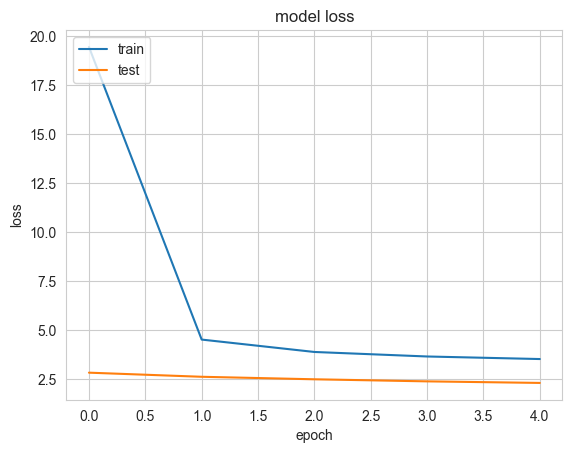

386/386 [==============================] - 71s 184ms/step
Top-1 accuracy: 0.3125670127988408
Top-5 accuracy: 0.48802060693874266
Top-10 accuracy: 0.5769822104161637


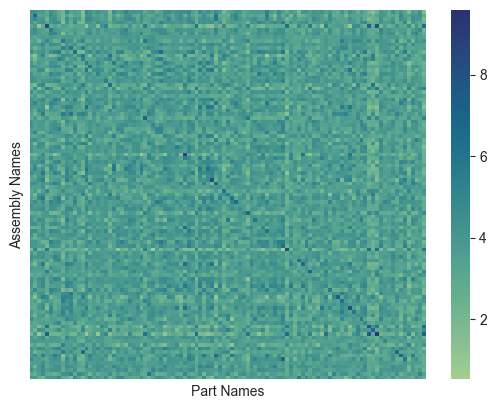

In [62]:
# configs = num_epochs, train_layers, temperature, pool_out, attention, fully_connected_layers
configs = [
           # [5, 1, 0.05, 'pool', False, None],
           # [5, 2, 0.05, 'pool', False, None],
           # [5, 1, 0.04, 'pool', False, None],
           # [5, 1, 0.06, 'pool', False, None],
           [5, 1, 0.05, 'cls', False, None],
           # [5, 1, 0.04, 'cls', False, None],
           # [5, 1, 0.06, 'cls', False, None],
           ]

for config in configs:
    print("\n\n\nnum_epochs, train_layers, temperature, pool_out, attention, fully_connected_layers")
    print(config)
    # Train the dual encoder model
    num_epochs = config[0]
    train_layers = config[1]
    temperature = config[2]
    pool_out = config[3]
    attention = config[4]
    fully_connected_layers = config[5]

    text_encoder = create_text_encoder(train_layers=train_layers, max_length=128, pool_token=pool_out, attention=attention, fully_connected_layers=fully_connected_layers)
    text_encoder.summary()
    dual_encoder = DualEncoder(text_encoder, temperature=temperature)
    dual_encoder.compile(optimizer=tfa.optimizers.AdamW(learning_rate=0.001, weight_decay=0.001))

    train_data_generator = DataGeneratorFromFile(
        tokenizer=bert_tokenizer,
        n_examples=len(pd.read_csv(train_data_path)),
        data_filename=train_data_path,
        batch_size=100
    )

    # Create a learning rate scheduler callback.
    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3)
    # Create an early stopping callback.
    # early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

    history = dual_encoder.fit(
        train_data_generator,
        epochs=num_epochs,
        validation_data=test_data_preprocessed,
        callbacks=[reduce_lr] #, early_stopping],
    )
    print("Training completed. Saving text encoder...")
    model_name = f"text_encoder_{num_epochs}_{train_layers}_{pool_out}_{temperature}_{attention}_{fully_connected_layers}"
    text_encoder.save(model_name)
    print(f"Model is saved: {model_name}.")

    visualize_history(history)

    # Evaluate
    # Generate embeddings for the test data
    test_part_embeddings = text_encoder.predict(test_data_preprocessed['part_inputs'])
    test_assembly_embeddings = text_encoder.predict(test_data_preprocessed['assembly_inputs'])

    # batch the embeddings into sets of 100
    batch_size = 100
    test_part_embeddings = np.array_split(test_part_embeddings, len(test_part_embeddings) / batch_size)
    test_assembly_embeddings = np.array_split(test_assembly_embeddings, len(test_assembly_embeddings) / batch_size)

    similarity_batches = evaluate_similarity(test_part_embeddings, test_assembly_embeddings)
    evaluate_accuracy(similarity_batches)

    ax = sns.heatmap(similarity_batches[0], cmap="crest", xticklabels=False, yticklabels=False) #, annot=True)
    ax.set(xlabel="Part Names", ylabel="Assembly Names") #, title="Cosine Similarity Between Assembly Names and Part Names")
    plt.show()

## Network architecture search




num_epochs, train_layers, temperature, pool_out, attention, fully_connected_layers
[5, 1, 0.05, 'pool', False, None]


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/5


492/492 [==============================] - 575s 1s/step - loss: 331.4949 - val_loss: 3.8204 - lr: 0.0010
Epoch 2/5
492/492 [==============================] - 580s 1s/step - loss: 68.4866 - val_loss: 4.9680 - lr: 0.0010
Epoch 3/5
492/492 [==============================] - 583s 1s/step - loss: 87.5256 - val_loss: 3.7301 - lr: 0.0010
Epoch 4/5
492/492 [==============================] - 586s 1s/step - loss: 97.4802 - val_loss: 5.9909 - lr: 0.0010
Epoch 5/5
492/492 [==============================] - 586s 1s/step - loss: 250.0744 - val_loss: 588.4470 - lr: 0.0010
Training completed. Saving text encoder...


INFO:tensorflow:Assets written to: text_encoder_5_1_pool_0.05_False_None\assets


INFO:tensorflow:Assets written to: text_encoder_5_1_pool_0.05_False_None\assets


Model is saved: text_encoder_5_1_pool_0.05_False_None.


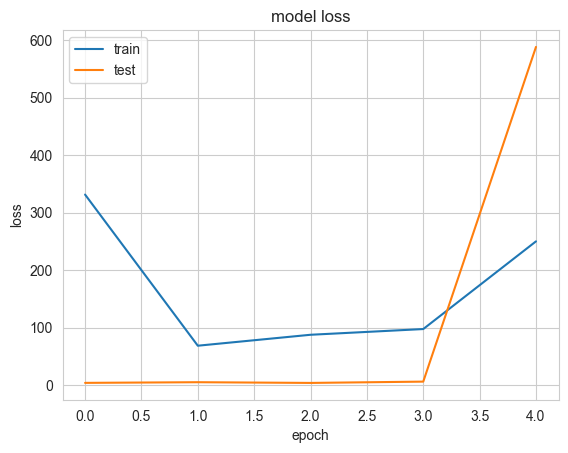

386/386 [==============================] - 65s 169ms/step
Top-1 accuracy: 0.009657892618530145
Top-5 accuracy: 0.0499146743942687
Top-10 accuracy: 0.10031795862513081



num_epochs, train_layers, temperature, pool_out, attention, fully_connected_layers
[5, -1, 0.05, 'cls', True, None]


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


IndexError: Exception encountered when calling layer "softmax" "                 f"(type Softmax).

tuple index out of range

Call arguments received by layer "softmax" "                 f"(type Softmax):
  • inputs=tf.Tensor(shape=(None, 4), dtype=float32)
  • mask=None

In [73]:
# configs = num_epochs, train_layers, temperature, pool_out, attention, fully_connected_layers
configs = [[5, 1, 0.05, 'pool', False, None]
           ]

for config in configs:
    print("\n\n\nnum_epochs, train_layers, temperature, pool_out, attention, fully_connected_layers")
    print(config)
    # Train the dual encoder model
    num_epochs = config[0]
    train_layers = config[1]
    temperature = config[2]
    pool_out = config[3]
    attention = config[4]
    fully_connected_layers = config[5]

    text_encoder = create_text_encoder(train_layers=train_layers, max_length=128, pool_token=pool_out, attention=attention, fully_connected_layers=fully_connected_layers)
    dual_encoder = DualEncoder(text_encoder, temperature=temperature)
    dual_encoder.compile(optimizer=tfa.optimizers.AdamW(learning_rate=0.001, weight_decay=0.001))

    train_data_generator = DataGeneratorFromFile(
        tokenizer=bert_tokenizer,
        n_examples=len(pd.read_csv(train_data_path)),
        data_filename=train_data_path,
        batch_size=100
    )

    # Create a learning rate scheduler callback.
    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3)
    # Create an early stopping callback.
    # early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

    history = dual_encoder.fit(
        train_data_generator,
        epochs=num_epochs,
        validation_data=test_data_preprocessed,
        callbacks=[reduce_lr] # , early_stopping],
    )
    print("Training completed. Saving text encoder...")
    model_name = f"text_encoder_{num_epochs}_{train_layers}_{pool_out}_{temperature}_{attention}_{fully_connected_layers}"
    text_encoder.save(model_name)
    print(f"Model is saved: {model_name}.")

    visualize_history(history)

    # Evaluate
    # Generate embeddings for the test data
    test_part_embeddings = text_encoder.predict(test_data_preprocessed['part_inputs'])
    test_assembly_embeddings = text_encoder.predict(test_data_preprocessed['assembly_inputs'])

    # batch the embeddings into sets of 100
    batch_size = 100
    test_part_embeddings = np.array_split(test_part_embeddings, len(test_part_embeddings) / batch_size)
    test_assembly_embeddings = np.array_split(test_assembly_embeddings, len(test_assembly_embeddings) / batch_size)

    similarity_batches = evaluate_similarity(test_part_embeddings, test_assembly_embeddings)
    evaluate_accuracy(similarity_batches)




num_epochs, train_layers, temperature, pool_out, attention, fully_connected_layers
[5, 1, 0.05, 'cls', True, None]


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "text_encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                       

492/492 [==============================] - 622s 1s/step - loss: 5.0802 - val_loss: 3.4655 - lr: 0.0010
Epoch 2/5
492/492 [==============================] - 621s 1s/step - loss: 4.6052 - val_loss: 3.4655 - lr: 0.0010
Epoch 3/5
492/492 [==============================] - 622s 1s/step - loss: 4.6052 - val_loss: 3.4655 - lr: 0.0010
Epoch 4/5
492/492 [==============================] - 623s 1s/step - loss: 4.6052 - val_loss: 3.4655 - lr: 0.0010
Epoch 5/5
492/492 [==============================] - 623s 1s/step - loss: 4.6052 - val_loss: 3.4655 - lr: 2.0000e-04
Training completed. Saving text encoder...


INFO:tensorflow:Assets written to: text_encoder_5_1_cls_0.05_True_None\assets


INFO:tensorflow:Assets written to: text_encoder_5_1_cls_0.05_True_None\assets


Model is saved: text_encoder_5_1_cls_0.05_True_None.


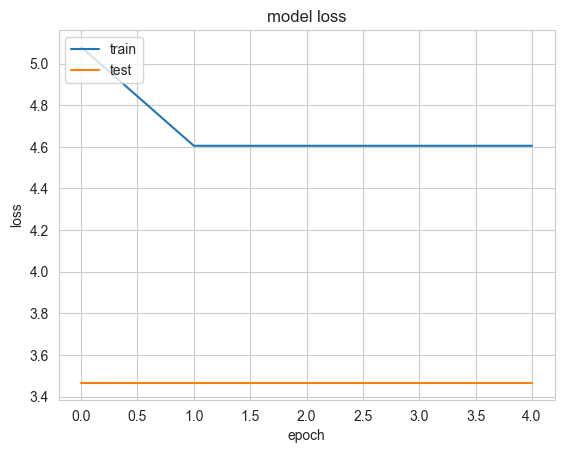

386/386 [==============================] - 73s 190ms/step
Top-1 accuracy: 0.009740803348627548
Top-5 accuracy: 0.049426869516219926
Top-10 accuracy: 0.09666183691539887


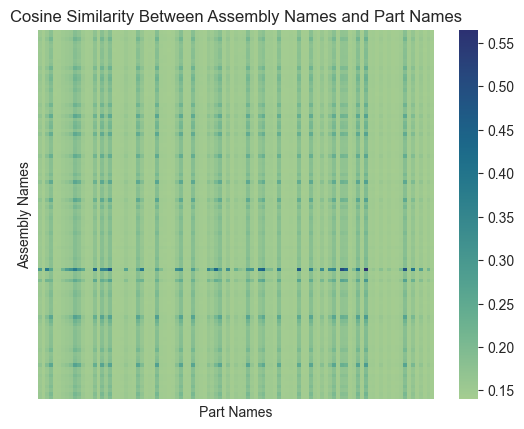




num_epochs, train_layers, temperature, pool_out, attention, fully_connected_layers
[5, -1, 0.05, 'cls', False, 1]


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "text_encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                       

INFO:tensorflow:Assets written to: text_encoder_5_-1_cls_0.05_False_1\assets


INFO:tensorflow:Assets written to: text_encoder_5_-1_cls_0.05_False_1\assets


Model is saved: text_encoder_5_-1_cls_0.05_False_1.


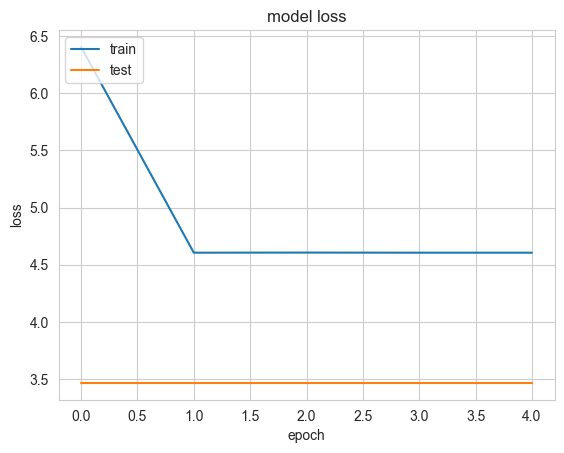

386/386 [==============================] - 72s 187ms/step
Top-1 accuracy: 0.009983095870562666
Top-5 accuracy: 0.04991547935281333
Top-10 accuracy: 0.09983095870562667


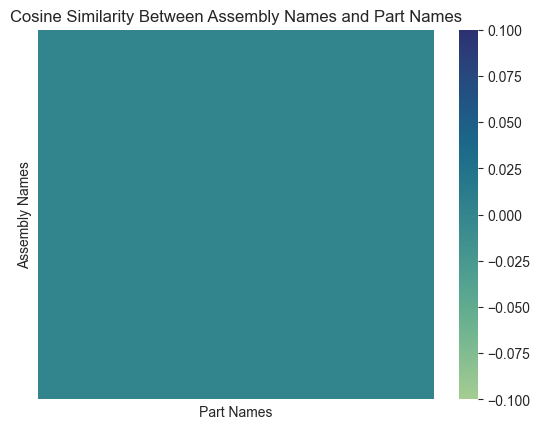




num_epochs, train_layers, temperature, pool_out, attention, fully_connected_layers
[5, -1, 0.05, 'cls', False, 2]


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "text_encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                       

INFO:tensorflow:Assets written to: text_encoder_5_-1_cls_0.05_False_2\assets


INFO:tensorflow:Assets written to: text_encoder_5_-1_cls_0.05_False_2\assets


Model is saved: text_encoder_5_-1_cls_0.05_False_2.


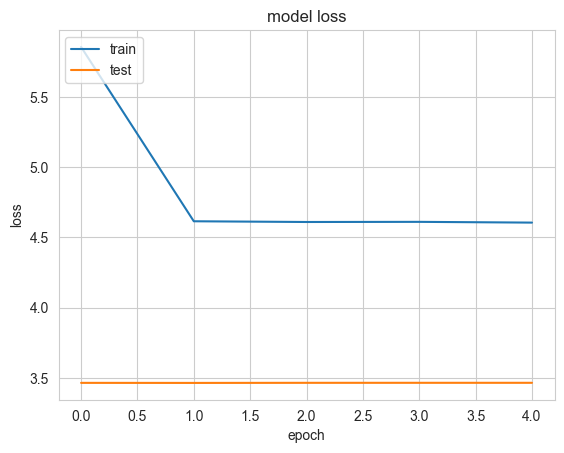

386/386 [==============================] - 72s 185ms/step
Top-1 accuracy: 0.009983095870562666
Top-5 accuracy: 0.04991547935281333
Top-10 accuracy: 0.09983095870562667


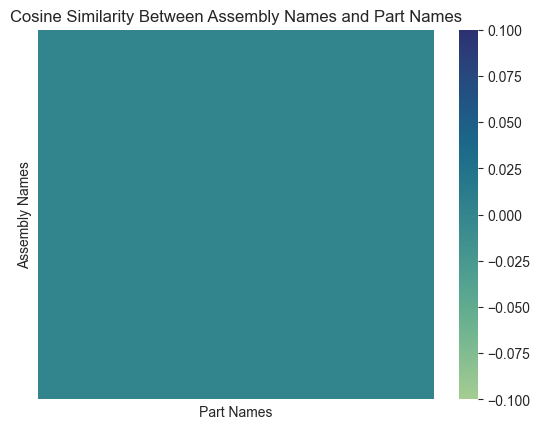




num_epochs, train_layers, temperature, pool_out, attention, fully_connected_layers
[5, -1, 0.05, 'cls', False, 3]


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "text_encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                       

INFO:tensorflow:Assets written to: text_encoder_5_-1_cls_0.05_False_3\assets


INFO:tensorflow:Assets written to: text_encoder_5_-1_cls_0.05_False_3\assets


Model is saved: text_encoder_5_-1_cls_0.05_False_3.


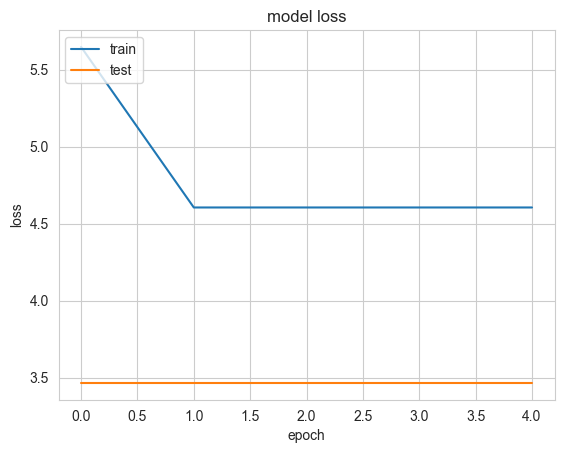

386/386 [==============================] - 71s 185ms/step
Top-1 accuracy: 0.010146502455123559
Top-5 accuracy: 0.05007808097882959
Top-10 accuracy: 0.1013700394429687


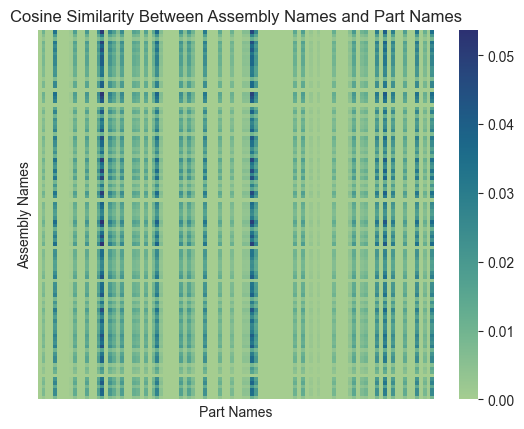




num_epochs, train_layers, temperature, pool_out, attention, fully_connected_layers
[5, -1, 0.05, 'cls', False, 4]


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "text_encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                       

INFO:tensorflow:Assets written to: text_encoder_5_-1_cls_0.05_False_4\assets


INFO:tensorflow:Assets written to: text_encoder_5_-1_cls_0.05_False_4\assets


Model is saved: text_encoder_5_-1_cls_0.05_False_4.


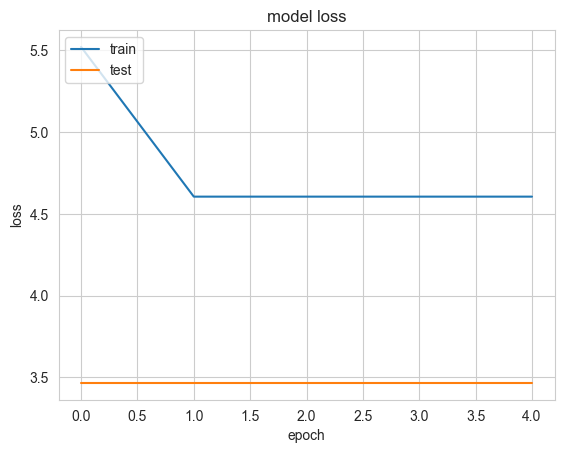

386/386 [==============================] - 73s 189ms/step
Top-1 accuracy: 0.009900990099009901
Top-5 accuracy: 0.05015857683329309
Top-10 accuracy: 0.10064316187716334


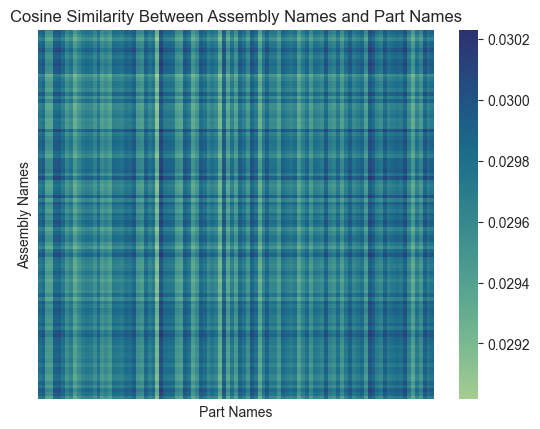




num_epochs, train_layers, temperature, pool_out, attention, fully_connected_layers
[5, -1, 0.05, 'cls', False, 5]


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "text_encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                       

INFO:tensorflow:Assets written to: text_encoder_5_-1_cls_0.05_False_5\assets


INFO:tensorflow:Assets written to: text_encoder_5_-1_cls_0.05_False_5\assets


Model is saved: text_encoder_5_-1_cls_0.05_False_5.


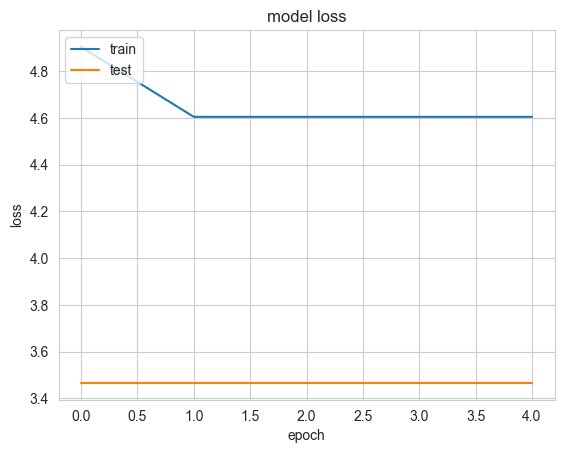

386/386 [==============================] - 73s 188ms/step
Top-1 accuracy: 0.009983095870562666
Top-5 accuracy: 0.04975287772679707
Top-10 accuracy: 0.09991225951863479


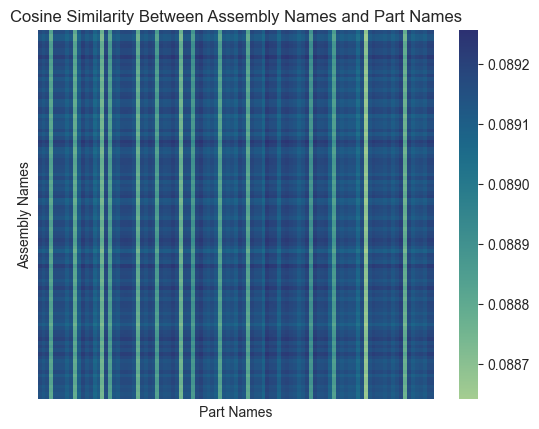




num_epochs, train_layers, temperature, pool_out, attention, fully_connected_layers
[5, -1, 0.05, 'cls', False, 6]


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "text_encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                       

INFO:tensorflow:Assets written to: text_encoder_5_-1_cls_0.05_False_6\assets


INFO:tensorflow:Assets written to: text_encoder_5_-1_cls_0.05_False_6\assets


Model is saved: text_encoder_5_-1_cls_0.05_False_6.


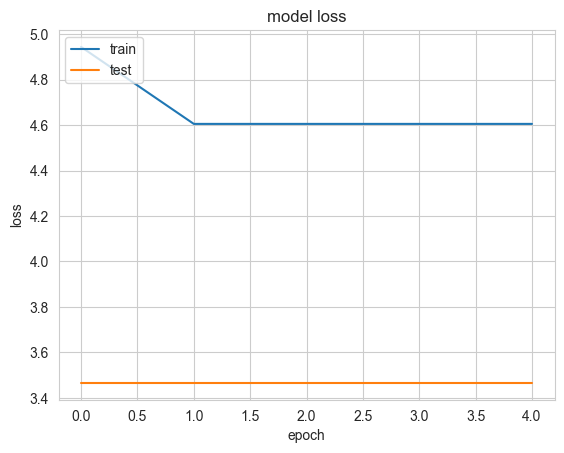

386/386 [==============================] - 73s 189ms/step
Top-1 accuracy: 0.010064396683570793
Top-5 accuracy: 0.049995975207276826
Top-10 accuracy: 0.09983095870562667


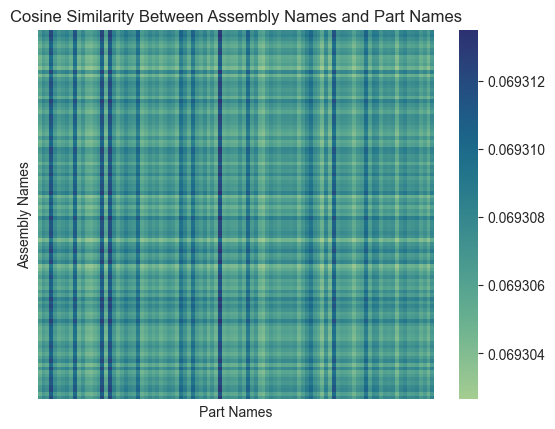




num_epochs, train_layers, temperature, pool_out, attention, fully_connected_layers
[5, -1, 0.05, 'cls', False, 7]


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "text_encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                       

INFO:tensorflow:Assets written to: text_encoder_5_-1_cls_0.05_False_7\assets


INFO:tensorflow:Assets written to: text_encoder_5_-1_cls_0.05_False_7\assets


Model is saved: text_encoder_5_-1_cls_0.05_False_7.


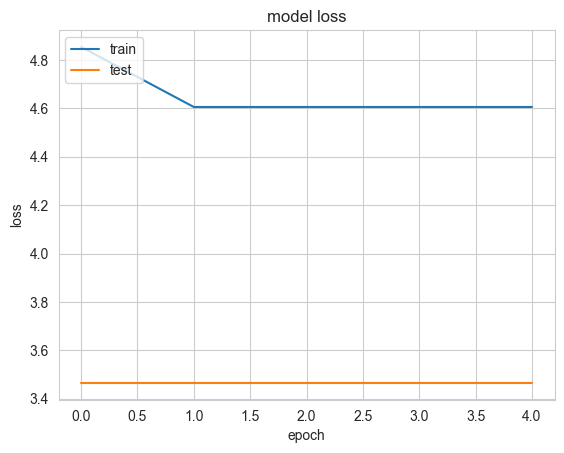

386/386 [==============================] - 73s 189ms/step
Top-1 accuracy: 0.010544956934717862
Top-5 accuracy: 0.05080495854463496
Top-10 accuracy: 0.10088142960637529


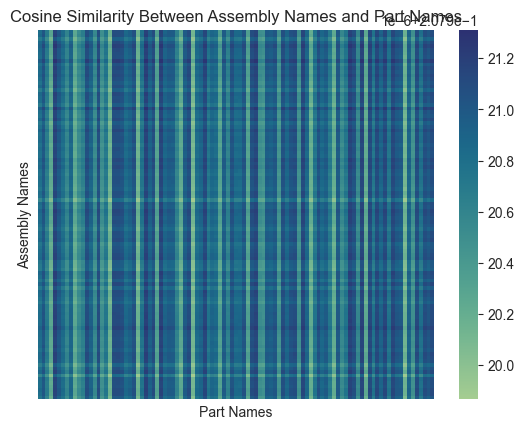




num_epochs, train_layers, temperature, pool_out, attention, fully_connected_layers
[5, -1, 0.05, 'cls', False, 8]


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "text_encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                       

INFO:tensorflow:Assets written to: text_encoder_5_-1_cls_0.05_False_8\assets


INFO:tensorflow:Assets written to: text_encoder_5_-1_cls_0.05_False_8\assets


Model is saved: text_encoder_5_-1_cls_0.05_False_8.


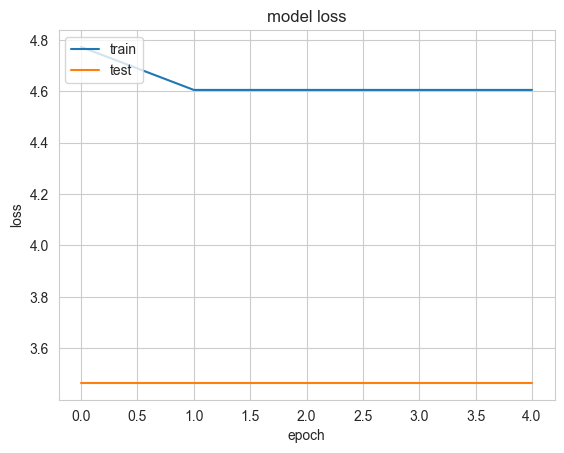

386/386 [==============================] - 75s 194ms/step
Top-1 accuracy: 0.010222973516863881
Top-5 accuracy: 0.04959430089350398
Top-10 accuracy: 0.1007252676487161


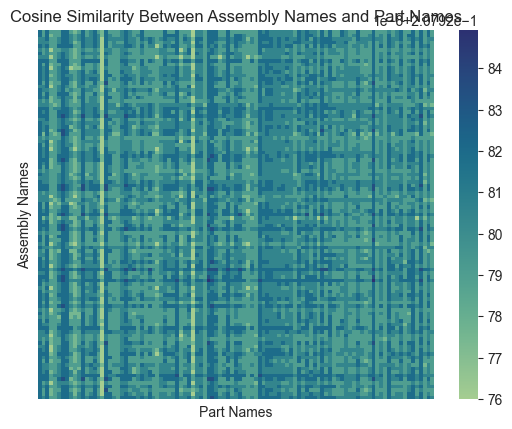

In [47]:
# configs = num_epochs, train_layers, temperature, pool_out, attention, fully_connected_layers
configs = [
            [5, 1, 0.05, 'cls', True, None],
           [5, -1, 0.05, 'cls', False, 1],
           [5, -1, 0.05, 'cls', False, 2],
           [5, -1, 0.05, 'cls', False, 3],
           [5, -1, 0.05, 'cls', False, 4],
           [5, -1, 0.05, 'cls', False, 5],
           [5, -1, 0.05, 'cls', False, 6],
           [5, -1, 0.05, 'cls', False, 7],
           [5, -1, 0.05, 'cls', False, 8],
           ]

for config in configs:
    print("\n\n\nnum_epochs, train_layers, temperature, pool_out, attention, fully_connected_layers")
    print(config)
    # Train the dual encoder model
    num_epochs = config[0]
    train_layers = config[1]
    temperature = config[2]
    pool_out = config[3]
    attention = config[4]
    fully_connected_layers = config[5]

    text_encoder = create_text_encoder(train_layers=train_layers, max_length=128, pool_token=pool_out, attention=attention, fully_connected_layers=fully_connected_layers)
    text_encoder.summary()
    dual_encoder = DualEncoder(text_encoder, temperature=temperature)
    dual_encoder.compile(optimizer=tfa.optimizers.AdamW(learning_rate=0.001, weight_decay=0.001))

    train_data_generator = DataGeneratorFromFile(
        tokenizer=bert_tokenizer,
        n_examples=len(pd.read_csv(train_data_path)),
        data_filename=train_data_path,
        batch_size=100
    )

    # Create a learning rate scheduler callback.
    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3)
    # Create an early stopping callback.
    # early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

    history = dual_encoder.fit(
        train_data_generator,
        epochs=num_epochs,
        validation_data=test_data_preprocessed,
        callbacks=[reduce_lr] # , early_stopping],
    )
    print("Training completed. Saving text encoder...")
    model_name = f"text_encoder_{num_epochs}_{train_layers}_{pool_out}_{temperature}_{attention}_{fully_connected_layers}"
    text_encoder.save(model_name)
    print(f"Model is saved: {model_name}.")

    visualize_history(history)

    # Evaluate
    # Generate embeddings for the test data
    test_part_embeddings = text_encoder.predict(test_data_preprocessed['part_inputs'])
    test_assembly_embeddings = text_encoder.predict(test_data_preprocessed['assembly_inputs'])

    # batch the embeddings into sets of 100
    batch_size = 100
    test_part_embeddings = np.array_split(test_part_embeddings, len(test_part_embeddings) / batch_size)
    test_assembly_embeddings = np.array_split(test_assembly_embeddings, len(test_assembly_embeddings) / batch_size)

    similarity_batches = evaluate_similarity(test_part_embeddings, test_assembly_embeddings)
    evaluate_accuracy(similarity_batches)

    ax = sns.heatmap(similarity_batches[0], cmap="crest", xticklabels=False, yticklabels=False) #, annot=True)
    ax.set(xlabel="Part Names", ylabel="Assembly Names", title="Cosine Similarity Between Assembly Names and Part Names")
    plt.show()




num_epochs, train_layers, temperature, pool_out, attention, fully_connected_layers
[5, 2, 0.05, 'cls', True, None]


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "text_encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                       

492/492 [==============================] - 714s 1s/step - loss: 5.2737 - val_loss: 3.4655 - lr: 0.0010
Epoch 2/5
492/492 [==============================] - 688s 1s/step - loss: 4.6052 - val_loss: 3.4655 - lr: 0.0010
Epoch 3/5
492/492 [==============================] - 686s 1s/step - loss: 4.6052 - val_loss: 3.4655 - lr: 0.0010
Epoch 4/5
492/492 [==============================] - 686s 1s/step - loss: 4.6052 - val_loss: 3.4655 - lr: 0.0010
Training completed. Saving text encoder...


INFO:tensorflow:Assets written to: text_encoder_5_2_cls_0.05_True_None\assets


INFO:tensorflow:Assets written to: text_encoder_5_2_cls_0.05_True_None\assets


Model is saved: text_encoder_5_2_cls_0.05_True_None.


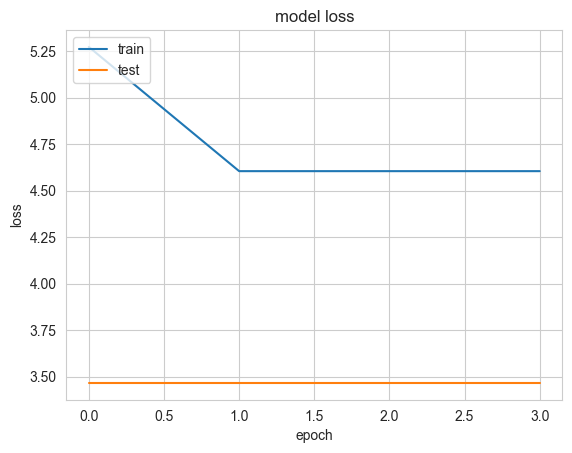

386/386 [==============================] - 74s 191ms/step
Top-1 accuracy: 0.01006359172502616
Top-5 accuracy: 0.049996780165821465
Top-10 accuracy: 0.10015535699911456


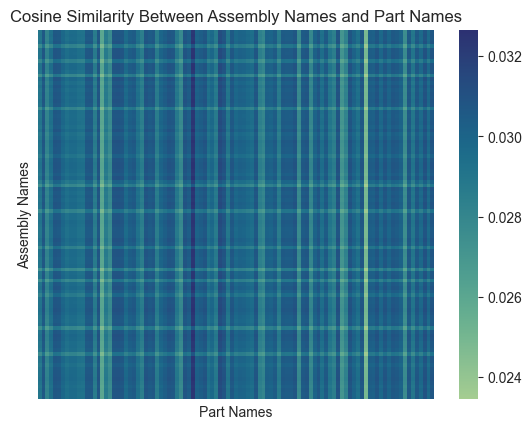




num_epochs, train_layers, temperature, pool_out, attention, fully_connected_layers
[5, 2, 0.05, 'cls', False, 1]


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "text_encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                       

492/492 [==============================] - 671s 1s/step - loss: 7.1937 - val_loss: 3.4655 - lr: 0.0010
Epoch 2/5
492/492 [==============================] - 650s 1s/step - loss: 4.6052 - val_loss: 3.4655 - lr: 0.0010
Epoch 3/5
492/492 [==============================] - 650s 1s/step - loss: 4.6052 - val_loss: 3.4655 - lr: 0.0010
Epoch 4/5
492/492 [==============================] - 652s 1s/step - loss: 4.6052 - val_loss: 3.4655 - lr: 0.0010
Training completed. Saving text encoder...


INFO:tensorflow:Assets written to: text_encoder_5_2_cls_0.05_False_1\assets


INFO:tensorflow:Assets written to: text_encoder_5_2_cls_0.05_False_1\assets


Model is saved: text_encoder_5_2_cls_0.05_False_1.


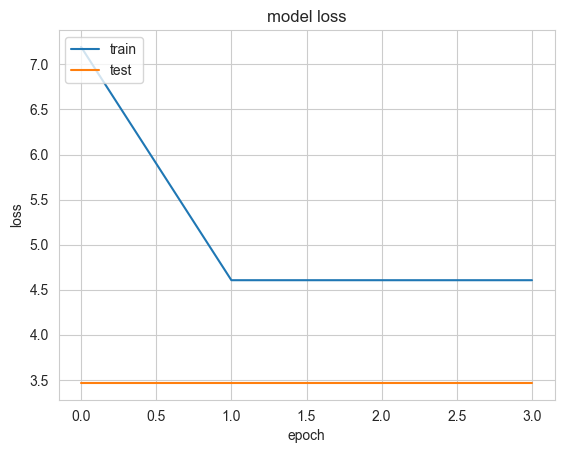

386/386 [==============================] - 74s 192ms/step
Top-1 accuracy: 0.009983095870562666
Top-5 accuracy: 0.04991547935281333
Top-10 accuracy: 0.09983095870562667


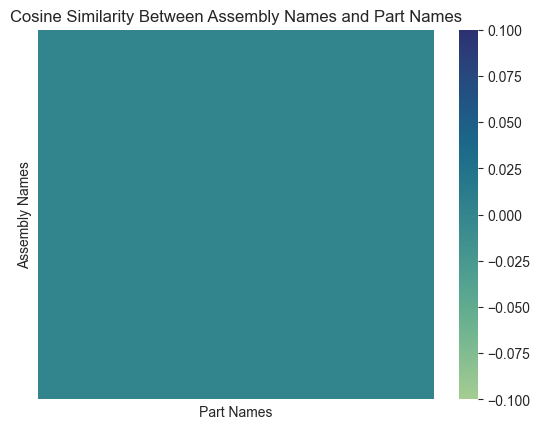




num_epochs, train_layers, temperature, pool_out, attention, fully_connected_layers
[5, 2, 0.05, 'cls', False, 2]


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "text_encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                       

492/492 [==============================] - 677s 1s/step - loss: 6.4644 - val_loss: 3.4655 - lr: 0.0010
Epoch 2/5
492/492 [==============================] - 655s 1s/step - loss: 4.6052 - val_loss: 3.4655 - lr: 0.0010
Epoch 3/5
492/492 [==============================] - 653s 1s/step - loss: 4.6052 - val_loss: 3.4655 - lr: 0.0010
Epoch 4/5
492/492 [==============================] - 654s 1s/step - loss: 4.6052 - val_loss: 3.4655 - lr: 0.0010
Training completed. Saving text encoder...


INFO:tensorflow:Assets written to: text_encoder_5_2_cls_0.05_False_2\assets


INFO:tensorflow:Assets written to: text_encoder_5_2_cls_0.05_False_2\assets


Model is saved: text_encoder_5_2_cls_0.05_False_2.


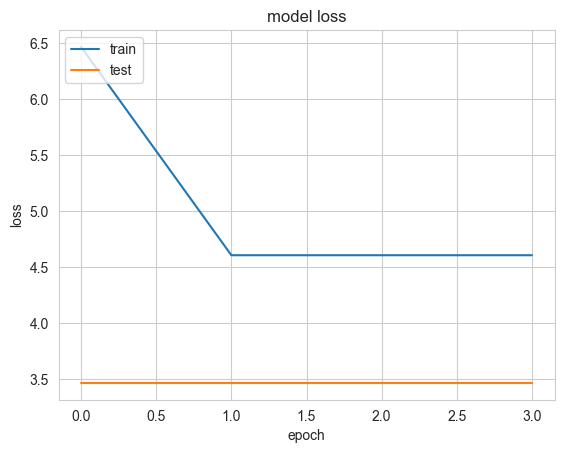

386/386 [==============================] - 74s 192ms/step
Top-1 accuracy: 0.011527811317717136
Top-5 accuracy: 0.05665137245431861
Top-10 accuracy: 0.10908717701038398


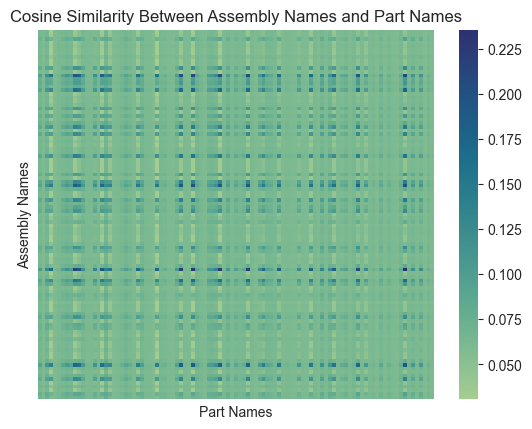




num_epochs, train_layers, temperature, pool_out, attention, fully_connected_layers
[5, 2, 0.05, 'cls', False, 3]


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "text_encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                       

492/492 [==============================] - 676s 1s/step - loss: 6.7989 - val_loss: 3.4655 - lr: 0.0010
Epoch 2/5
492/492 [==============================] - 650s 1s/step - loss: 4.6052 - val_loss: 3.4655 - lr: 0.0010
Epoch 3/5
492/492 [==============================] - 649s 1s/step - loss: 4.6052 - val_loss: 3.4655 - lr: 0.0010
Epoch 4/5
492/492 [==============================] - 650s 1s/step - loss: 4.6052 - val_loss: 3.4655 - lr: 0.0010
Training completed. Saving text encoder...


INFO:tensorflow:Assets written to: text_encoder_5_2_cls_0.05_False_3\assets


INFO:tensorflow:Assets written to: text_encoder_5_2_cls_0.05_False_3\assets


Model is saved: text_encoder_5_2_cls_0.05_False_3.


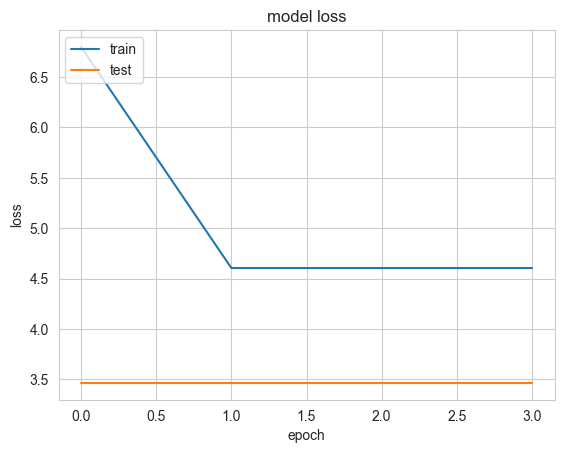

386/386 [==============================] - 73s 188ms/step
Top-1 accuracy: 0.011683973275376318
Top-5 accuracy: 0.060380745391612346
Top-10 accuracy: 0.11826048458504386


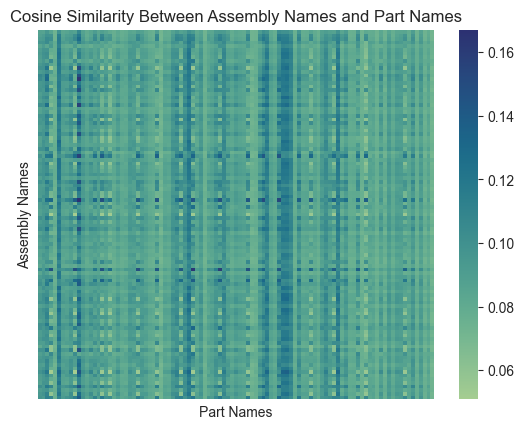




num_epochs, train_layers, temperature, pool_out, attention, fully_connected_layers
[5, 2, 0.05, 'cls', False, 4]


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "text_encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                       

492/492 [==============================] - 673s 1s/step - loss: 5.3854 - val_loss: 3.4655 - lr: 0.0010
Epoch 2/5
492/492 [==============================] - 650s 1s/step - loss: 4.6052 - val_loss: 3.4655 - lr: 0.0010
Epoch 3/5
492/492 [==============================] - 653s 1s/step - loss: 4.6052 - val_loss: 3.4655 - lr: 0.0010
Epoch 4/5
492/492 [==============================] - 655s 1s/step - loss: 4.6052 - val_loss: 3.4655 - lr: 0.0010
Training completed. Saving text encoder...


INFO:tensorflow:Assets written to: text_encoder_5_2_cls_0.05_False_4\assets


INFO:tensorflow:Assets written to: text_encoder_5_2_cls_0.05_False_4\assets


Model is saved: text_encoder_5_2_cls_0.05_False_4.


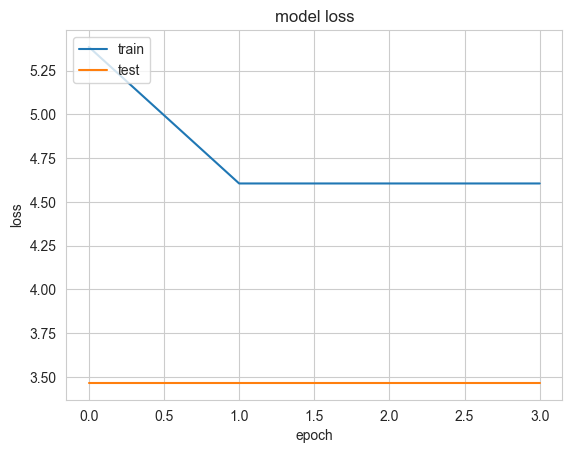

386/386 [==============================] - 74s 192ms/step
Top-1 accuracy: 0.008439990340497465
Top-5 accuracy: 0.04691137406423569
Top-10 accuracy: 0.09471947194719472


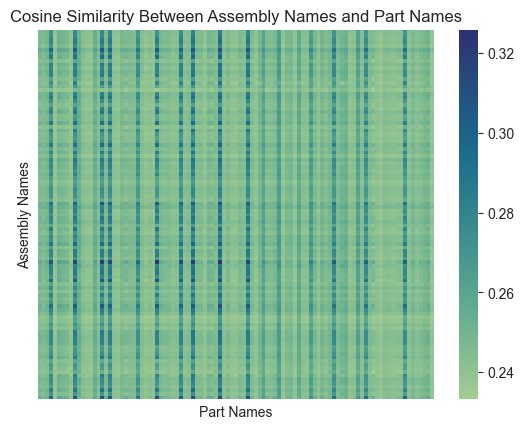

In [48]:
# configs = num_epochs, train_layers, temperature, pool_out, attention, fully_connected_layers
configs = [
           [5, 2, 0.05, 'cls', True, None],
           [5, 2, 0.05, 'cls', False, 1],
           [5, 2, 0.05, 'cls', False, 2],
           [5, 2, 0.05, 'cls', False, 3],
           [5, 2, 0.05, 'cls', False, 4],
           ]

for config in configs:
    print("\n\n\nnum_epochs, train_layers, temperature, pool_out, attention, fully_connected_layers")
    print(config)
    # Train the dual encoder model
    num_epochs = config[0]
    train_layers = config[1]
    temperature = config[2]
    pool_out = config[3]
    attention = config[4]
    fully_connected_layers = config[5]

    text_encoder = create_text_encoder(train_layers=train_layers, max_length=128, pool_token=pool_out, attention=attention, fully_connected_layers=fully_connected_layers)
    text_encoder.summary()
    dual_encoder = DualEncoder(text_encoder, temperature=temperature)
    dual_encoder.compile(optimizer=tfa.optimizers.AdamW(learning_rate=0.001, weight_decay=0.001))

    train_data_generator = DataGeneratorFromFile(
        tokenizer=bert_tokenizer,
        n_examples=len(pd.read_csv(train_data_path)),
        data_filename=train_data_path,
        batch_size=100
    )

    # Create a learning rate scheduler callback.
    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3)
    # Create an early stopping callback.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

    history = dual_encoder.fit(
        train_data_generator,
        epochs=num_epochs,
        validation_data=test_data_preprocessed,
        callbacks=[reduce_lr, early_stopping],
    )
    print("Training completed. Saving text encoder...")
    model_name = f"text_encoder_{num_epochs}_{train_layers}_{pool_out}_{temperature}_{attention}_{fully_connected_layers}"
    text_encoder.save(model_name)
    print(f"Model is saved: {model_name}.")

    visualize_history(history)

    # Evaluate
    # Generate embeddings for the test data
    test_part_embeddings = text_encoder.predict(test_data_preprocessed['part_inputs'])
    test_assembly_embeddings = text_encoder.predict(test_data_preprocessed['assembly_inputs'])

    # batch the embeddings into sets of 100
    batch_size = 100
    test_part_embeddings = np.array_split(test_part_embeddings, len(test_part_embeddings) / batch_size)
    test_assembly_embeddings = np.array_split(test_assembly_embeddings, len(test_assembly_embeddings) / batch_size)

    similarity_batches = evaluate_similarity(test_part_embeddings, test_assembly_embeddings)
    evaluate_accuracy(similarity_batches)

    ax = sns.heatmap(similarity_batches[0], cmap="crest", xticklabels=False, yticklabels=False) #, annot=True)
    ax.set(xlabel="Part Names", ylabel="Assembly Names", title="Cosine Similarity Between Assembly Names and Part Names")
    plt.show()




num_epochs, train_layers, temperature, pool_out, attention, fully_connected_layers
[5, 2, 0.05, 'cls', False, 1]


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "text_encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                       

INFO:tensorflow:Assets written to: text_encoder_5_2_cls_0.05_False_1\assets


INFO:tensorflow:Assets written to: text_encoder_5_2_cls_0.05_False_1\assets


Model is saved: text_encoder_5_2_cls_0.05_False_1.


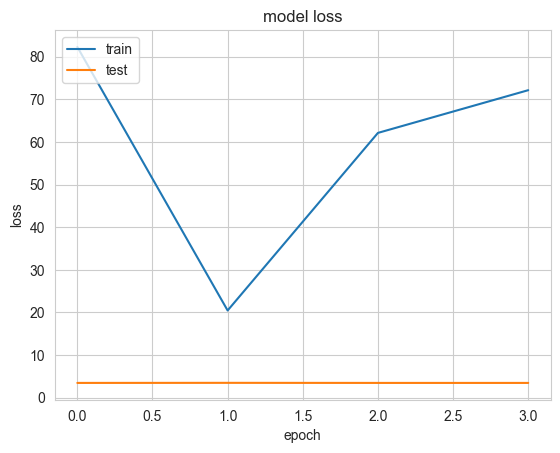

386/386 [==============================] - 70s 181ms/step
Top-1 accuracy: 0.010064396683570793
Top-5 accuracy: 0.04942767447476456
Top-10 accuracy: 0.09974724301698464


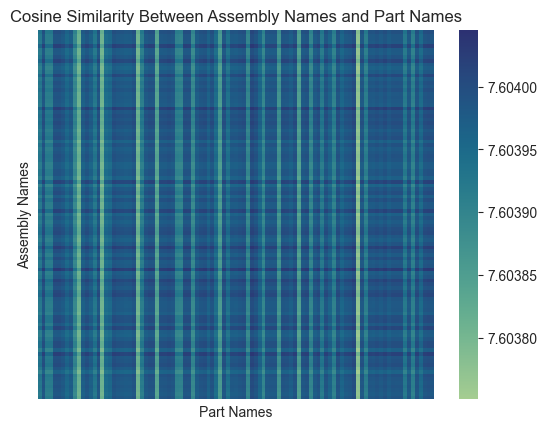




num_epochs, train_layers, temperature, pool_out, attention, fully_connected_layers
[5, 2, 0.05, 'cls', False, 2]


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "text_encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                       

492/492 [==============================] - 666s 1s/step - loss: 52.2374 - val_loss: 3.4655 - lr: 0.0010
Epoch 2/5
492/492 [==============================] - 646s 1s/step - loss: 5.5060 - val_loss: 3.4655 - lr: 0.0010
Epoch 3/5
492/492 [==============================] - 648s 1s/step - loss: 5.9957 - val_loss: 3.4655 - lr: 0.0010
Epoch 4/5
492/492 [==============================] - 650s 1s/step - loss: 6.2846 - val_loss: 3.4658 - lr: 0.0010
Training completed. Saving text encoder...


INFO:tensorflow:Assets written to: text_encoder_5_2_cls_0.05_False_2\assets


INFO:tensorflow:Assets written to: text_encoder_5_2_cls_0.05_False_2\assets


Model is saved: text_encoder_5_2_cls_0.05_False_2.


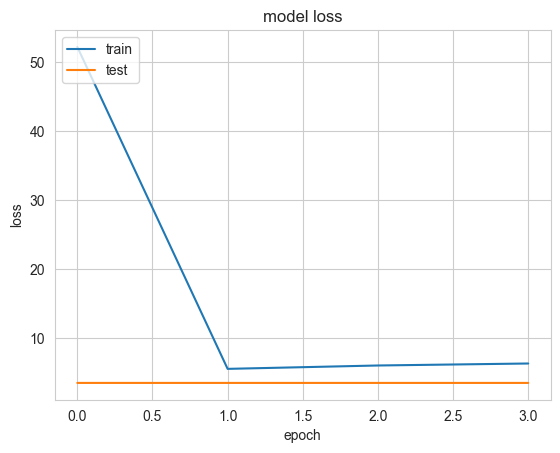

386/386 [==============================] - 72s 186ms/step
Top-1 accuracy: 0.009901795057554534
Top-5 accuracy: 0.051867503823553096
Top-10 accuracy: 0.10178298317636642


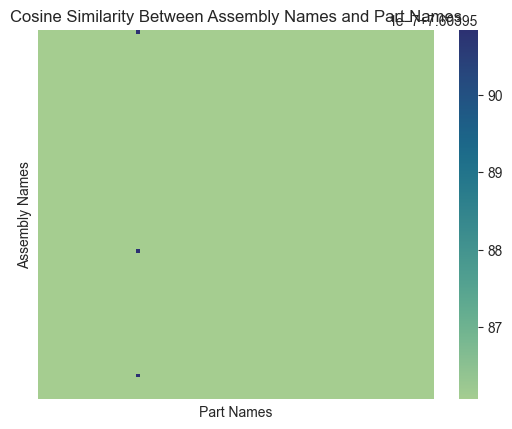




num_epochs, train_layers, temperature, pool_out, attention, fully_connected_layers
[5, 2, 0.05, 'cls', False, 3]


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "text_encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                       

492/492 [==============================] - 672s 1s/step - loss: 24.2534 - val_loss: 3.4655 - lr: 0.0010
Epoch 2/5
492/492 [==============================] - 652s 1s/step - loss: 5.3367 - val_loss: 3.4655 - lr: 0.0010
Epoch 3/5
492/492 [==============================] - 653s 1s/step - loss: 38.5191 - val_loss: 3.4741 - lr: 0.0010
Epoch 4/5
492/492 [==============================] - 653s 1s/step - loss: 4.8781 - val_loss: 3.4733 - lr: 0.0010
Epoch 5/5
492/492 [==============================] - 652s 1s/step - loss: 7.5531 - val_loss: 3.5211 - lr: 2.0000e-04
Training completed. Saving text encoder...


INFO:tensorflow:Assets written to: text_encoder_5_2_cls_0.05_False_3\assets


INFO:tensorflow:Assets written to: text_encoder_5_2_cls_0.05_False_3\assets


Model is saved: text_encoder_5_2_cls_0.05_False_3.


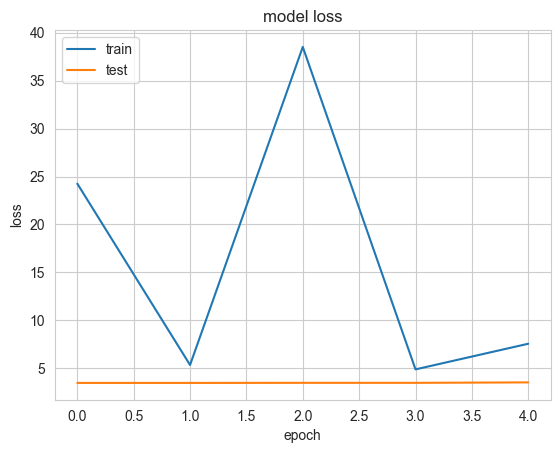

386/386 [==============================] - 72s 186ms/step
Top-1 accuracy: 0.009414795138050392
Top-5 accuracy: 0.04950656041213877
Top-10 accuracy: 0.09772116236013846


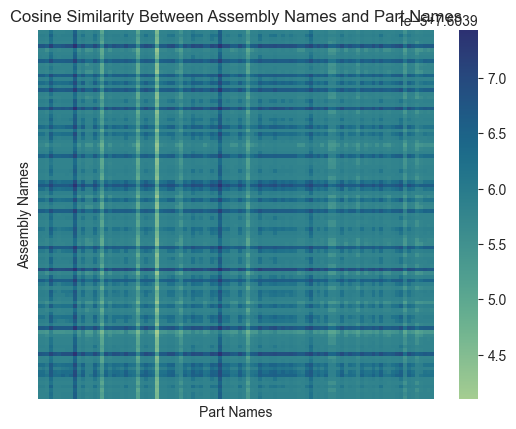




num_epochs, train_layers, temperature, pool_out, attention, fully_connected_layers
[5, 2, 0.05, 'cls', False, 4]


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "text_encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                       

492/492 [==============================] - 677s 1s/step - loss: 24.1293 - val_loss: 3.4655 - lr: 0.0010
Epoch 2/5
492/492 [==============================] - 651s 1s/step - loss: 5.2813 - val_loss: 3.4655 - lr: 0.0010
Epoch 3/5
492/492 [==============================] - 651s 1s/step - loss: 18.2337 - val_loss: 3.4655 - lr: 0.0010
Epoch 4/5
492/492 [==============================] - 650s 1s/step - loss: 4.9110 - val_loss: 3.4655 - lr: 0.0010
Epoch 5/5
492/492 [==============================] - 650s 1s/step - loss: 6.7095 - val_loss: 3.4655 - lr: 2.0000e-04
Training completed. Saving text encoder...


INFO:tensorflow:Assets written to: text_encoder_5_2_cls_0.05_False_4\assets


INFO:tensorflow:Assets written to: text_encoder_5_2_cls_0.05_False_4\assets


Model is saved: text_encoder_5_2_cls_0.05_False_4.


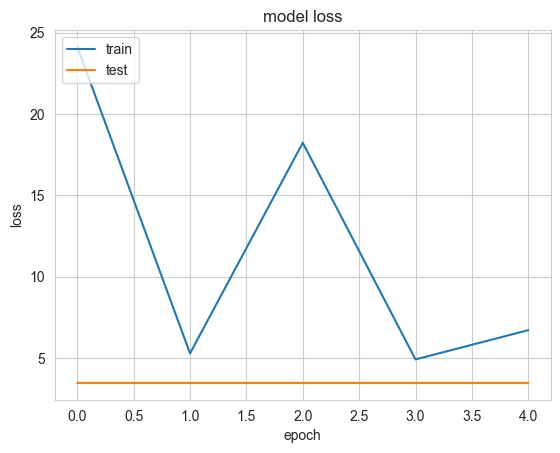

386/386 [==============================] - 71s 183ms/step
Top-1 accuracy: 0.009012315865732916
Top-5 accuracy: 0.05008854543990985
Top-10 accuracy: 0.10260001609917091


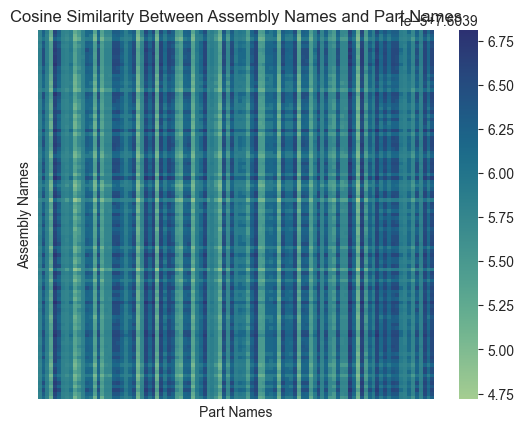

In [29]:
# after changing activation to tanh, and dropout to 0.2
# configs = num_epochs, train_layers, temperature, pool_out, attention, fully_connected_layers
configs = [
           # [5, 2, 0.05, 'cls', False, None],
           [5, 2, 0.05, 'cls', False, 1],
           [5, 2, 0.05, 'cls', False, 2],
           [5, 2, 0.05, 'cls', False, 3],
           [5, 2, 0.05, 'cls', False, 4],
           ]

for config in configs:
    print("\n\n\nnum_epochs, train_layers, temperature, pool_out, attention, fully_connected_layers")
    print(config)
    # Train the dual encoder model
    num_epochs = config[0]
    train_layers = config[1]
    temperature = config[2]
    pool_out = config[3]
    attention = config[4]
    fully_connected_layers = config[5]

    text_encoder = create_text_encoder(train_layers=train_layers, max_length=128, pool_token=pool_out, attention=attention, fully_connected_layers=fully_connected_layers)
    dual_encoder = DualEncoder(text_encoder, temperature=temperature)
    dual_encoder.compile(optimizer=tfa.optimizers.AdamW(learning_rate=0.001, weight_decay=0.001))

    train_data_generator = DataGeneratorFromFile(
        tokenizer=bert_tokenizer,
        n_examples=len(pd.read_csv(train_data_path)),
        data_filename=train_data_path,
        batch_size=100
    )

    # Create a learning rate scheduler callback.
    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3)
    # Create an early stopping callback.
    # early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

    history = dual_encoder.fit(
        train_data_generator,
        epochs=num_epochs,
        validation_data=test_data_preprocessed,
        callbacks=[reduce_lr]#, early_stopping],
    )
    text_encoder.summary()
    print("Training completed. Saving text encoder...")
    model_name = f"text_encoder_{num_epochs}_{train_layers}_{pool_out}_{temperature}_{attention}_{fully_connected_layers}"
    text_encoder.save(model_name)
    print(f"Model is saved: {model_name}.")

    visualize_history(history)

    # Evaluate
    # Generate embeddings for the test data
    test_part_embeddings = text_encoder.predict(test_data_preprocessed['part_inputs'])
    test_assembly_embeddings = text_encoder.predict(test_data_preprocessed['assembly_inputs'])

    # batch the embeddings into sets of 100
    batch_size = 100
    test_part_embeddings = np.array_split(test_part_embeddings, len(test_part_embeddings) / batch_size)
    test_assembly_embeddings = np.array_split(test_assembly_embeddings, len(test_assembly_embeddings) / batch_size)

    similarity_batches = evaluate_similarity(test_part_embeddings, test_assembly_embeddings)
    evaluate_accuracy(similarity_batches)

    ax = sns.heatmap(similarity_batches[0], cmap="crest", xticklabels=False, yticklabels=False) #, annot=True)
    ax.set(xlabel="Part Names", ylabel="Assembly Names") #, title="Cosine Similarity Between Assembly Names and Part Names")
    plt.show()

## Qualitative Evaluation

In [63]:
correct_examples = []
incorrect_examples = []

batch = similarity_batches[0]
k = 1
top_k_values = np.argsort(-batch, axis=1)[:,:k]
for index, row in enumerate(top_k_values):
    if index in row:
        # Correct example
        correct_examples.append([test_labels[index], test_strings[index]])
    else:
        # Incorrect example
        incorrect_examples.append([test_labels[index], test_strings[index]])

print(f"Number of correct examples: {len(correct_examples)}")
print(f"Number of incorrect examples: {len(incorrect_examples)}")
print(f"Percentage of correct examples: {len(correct_examples) / (len(incorrect_examples) + len(correct_examples))}")

Number of correct examples: 36
Number of incorrect examples: 65
Percentage of correct examples: 0.3564356435643564


In [70]:
print("Correct examples:")
for example in correct_examples[:100]:
    print(example)

Correct examples:
["An assembly with the name '20mm stack'", 'An assembly containing the following parts: 20mm stack.']
["An assembly with the name '2238 375.step'", 'An assembly containing the following parts: 2238 375.']
["An assembly with the name 'sleeve'", 'An assembly containing the following parts: cap, sleeve.']
["An assembly with the name 'ubicación guayacanes hermanos'", 'An assembly containing the following parts: perfile limaton, correa cuartos, base columna 3, perfile limaton 2, tapa perfil limaton, ubicaci\\x2\\00f3\\x0\\n villa luz google maps y levantamiento topografico 2, tapa limaton opuesto 2, correa corta cuartos.']
["An assembly with the name 'piggy bank plug'", 'An assembly containing the following parts: piggy bank plug.']
["An assembly with the name 'roller 1'", 'An assembly containing the following parts: roller4 1.']
["An assembly with the name 'houder bedlampje ikea'", 'An assembly containing the following parts: lamphoudertje.']
["An assembly with the name '

In [65]:
print("Incorrect examples:")
for example in incorrect_examples[:10]:
    print(example)

Incorrect examples:
["An assembly with the name 'box shell version'", 'An assembly containing the following parts: end 1, side 1, side 2, short divider, end 2, long divider.']
["An assembly with the name 'ww sport base bar box'", 'An assembly containing the following parts: internalcomb, basebottomkeyhalf, basebottomkeyotherhalf, boxlid, windholder, mainbox, barform, basetopkey.']
["An assembly with the name 'circle builder'", 'An assembly containing the following parts: nozzle, v slot 20x60x500 linear rail, fake support, 184, l 2112kk cage, carrage mount prt8, vt1m3x30, heater block^e3d nozzle v, 167, 145, turbine, 181, motor shaft, frame b3, boden lever arm, heater, component, 160, 182, timming pulley 16t g2, bed center, 175, fitting, 174, 149, bl touch, 183, 144, 159, arm, l 2112kk ir, frame b2, 151, vt3m4x12, steel tube, 142, l 2112kk ball, extruder bridge aluminium, 162, 178, boden frame, rail cross part, pivot shaft, 177, carrage prt6, 157, extruder grove wheel\\x2\\00d8\\x0\\13,

## Test

Top-1 accuracy: 0.3125670127988408
Top-5 accuracy: 0.48802060693874266
Top-10 accuracy: 0.5769822104161637


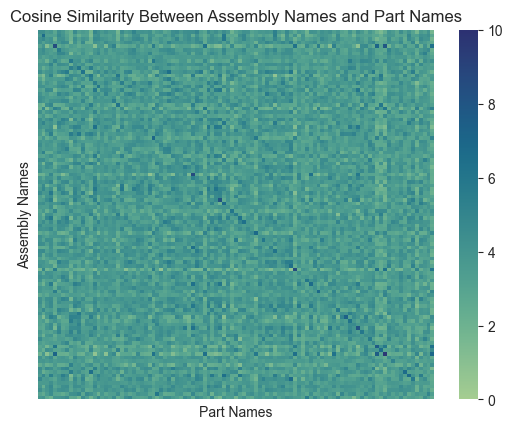

In [66]:
similarity_batches = evaluate_similarity(test_part_embeddings, test_assembly_embeddings)

ax = sns.heatmap(similarity_batches[0], cmap="crest", xticklabels=False, yticklabels=False, vmin=0, vmax=10) #, annot=True)
ax.set(xlabel="Part Names", ylabel="Assembly Names", title="Cosine Similarity Between Assembly Names and Part Names")
evaluate_accuracy(similarity_batches)

In [67]:
similarity_batches[0][0]

<tf.Tensor: shape=(101,), dtype=float32, numpy=
array([4.4010086, 4.453031 , 3.618114 , 3.8744051, 2.8252413, 4.393833 ,
       3.851563 , 2.7820053, 2.2027402, 4.624779 , 3.2644627, 3.609355 ,
       3.370409 , 1.7491325, 4.947238 , 4.3034744, 3.7064295, 4.191607 ,
       3.644918 , 3.6063   , 1.7598937, 4.5131593, 3.637158 , 3.94962  ,
       5.1096363, 4.031879 , 4.1251   , 3.9958742, 4.2652097, 2.8914163,
       3.641907 , 3.9714518, 2.8715606, 3.2628994, 4.3789883, 4.606826 ,
       3.7246258, 4.328679 , 4.451549 , 4.4061894, 4.977412 , 3.4697962,
       2.907953 , 4.5948668, 3.852888 , 4.3219934, 3.531698 , 4.494173 ,
       3.881192 , 1.9745382, 3.07178  , 3.6669102, 4.2469006, 4.1346345,
       3.0615172, 3.4038894, 3.8157067, 3.7362425, 3.9146771, 3.7660358,
       5.3332195, 3.729202 , 3.206717 , 4.7130527, 3.5327349, 2.722283 ,
       3.8077302, 3.4041598, 2.0179322, 4.1639705, 4.080251 , 3.457718 ,
       4.244617 , 3.9029012, 4.2769866, 3.3802557, 3.9554203, 3.0767434,
   

Top-1 accuracy: 0.3246502455123561
Top-5 accuracy: 0.4891531836110441
Top-10 accuracy: 0.5735627465185542


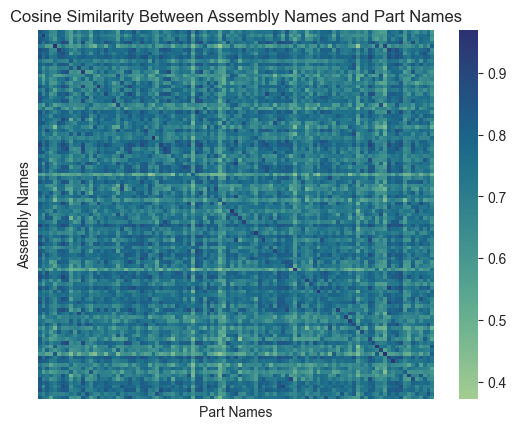

In [69]:
similarity_batches = evaluate_similarity(test_part_embeddings, test_assembly_embeddings, axis=1)

ax = sns.heatmap(similarity_batches[0], cmap="crest", xticklabels=False, yticklabels=False) #, vmin=0, vmax=10)
ax.set(xlabel="Part Names", ylabel="Assembly Names", title="Cosine Similarity Between Assembly Names and Part Names")
evaluate_accuracy(similarity_batches)